# ============================================================================
# KUESKI PORTFOLIO ANALYSIS - Q1 2025 (Jan, Feb, Mar)
# ============================================================================
# Objective: Assess profitability under current acquisition and pricing policies
# Make a recommendation: to keep or to change policies based on evidence and data
# ============================================================================


In [ ]:


import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from datetime import datetime

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Configurar tamaño de figuras
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

# Path correcto a la base de datos (desde analisis_adhoc/code/)
DB_PATH = '../../dbt/kueski_finance.duckdb'

# Conectar a DuckDB
conn = duckdb.connect(DB_PATH, read_only=True)

print("="*70)
print("✅ KUESKI PORTFOLIO ANALYSIS - INITIALIZED")
print("="*70)
print(f"Database: {DB_PATH}")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Scope: Q1 2025 (Jan, Feb, Mar)")
print("="*70)

✅ KUESKI PORTFOLIO ANALYSIS - INITIALIZED
Database: ../../dbt/kueski_finance.duckdb
Analysis Date: 2026-01-17 16:37:38
Scope: Q1 2025 (Jan, Feb, Mar)


# Q1 Vintages

In [5]:
# ============================================================================
# DATA SCOPE VERIFICATION - Q1 2025
# ============================================================================

# Verificar qué vintages tenemos disponibles
query_available = """
SELECT 
    vintage_month,
    vintage_year,
    COUNT(*) as total_loans,
    COUNT(DISTINCT user_id) as total_customers,
    ROUND(SUM(loan_amount), 2) as total_amount,
    ROUND(SUM(revenue), 2) as total_revenue,
    ROUND(SUM(net_profit), 2) as total_net_profit
FROM main.int_loan_financials
GROUP BY vintage_month, vintage_year
ORDER BY vintage_month DESC
LIMIT 12
"""

df_available = conn.execute(query_available).df()

print("\n" + "="*70)
print("AVAILABLE VINTAGES IN DATABASE")
print("="*70)
print(df_available.to_string(index=False))
print("="*70)

# Verificar si tenemos Q1 2025 (Enero, Febrero, Marzo)
q1_2025_months = df_available[
    (df_available['vintage_year'] == 2025) & 
    (df_available['vintage_month'].isin(['2025-01-01', '2025-02-01', '2025-03-01']))
]

if len(q1_2025_months) > 0:
    print(f"\n✅ Q1 2025 data found: {len(q1_2025_months)} months")
    print("\nQ1 2025 Summary:")
    print(q1_2025_months.to_string(index=False))
else:
    print("\n⚠️  WARNING: No Q1 2025 data found!")
    print("We'll use the most recent available data instead.")
    
    # Si no hay Q1 2025, usar los 3 meses más recientes
    most_recent = df_available.head(3)
    print("\nUsing most recent 3 months:")
    print(most_recent[['vintage_month', 'total_loans', 'total_customers']].to_string(index=False))


AVAILABLE VINTAGES IN DATABASE
vintage_month vintage_year  total_loans  total_customers  total_amount  total_revenue  total_net_profit
      2025-12         2025         1750              736  2,241,067.40      28,076.54       -137,730.18
      2025-11         2025         2155              857  3,009,398.82     225,633.22         -8,615.47
      2025-10         2025         1978              817  2,239,714.42     294,338.45        125,477.26
      2025-09         2025         1800              832  2,281,392.14     359,377.68        168,343.93
      2025-08         2025         2087              909  2,615,973.60     380,149.69        167,111.33
      2025-07         2025         2294             1043  2,898,951.80     455,636.92        195,545.69
      2025-06         2025         2277             1100  2,778,220.60     455,113.51        218,762.96
      2025-05         2025         2786             1275  3,524,194.94     592,152.07        276,753.52
      2025-04         2025      

# Create Q1 Dataset

In [ ]:

query_q1 = """
SELECT 
    -- IDs
    loan_id,
    user_id,
    
    -- Dates
    vintage_date,
    vintage_month,
    vintage_year,
    
    -- Loan attributes
    loan_amount,
    loan_term,
    interest_rate,
    loan_sequence_number,
    flg_first_loan_customer,
    flg_recurrent_customer,
    
    -- Customer attributes
    risk_segment_customer,
    risk_band_production_customer,
    channel_customer,
    state_customer,
    
    -- Financial metrics (NEW STRUCTURE)
    revenue,
    interest_revenue,
    fee_revenue,
    penalty_revenue,
    
    -- Costs (SEPARATED)
    funding_cost,
    credit_loss,
    cogs,
    cac,
    
    -- Margins (NEW WATERFALL)
    financial_margin,
    contribution_margin,
    net_profit,
    
    -- Recovery & Delinquency
    principal_repaid,
    recovery_rate,
    delinquency_status,
    is_delinquent,
    dpd_bucket,
    capital_balance,
    
    -- Funding rates (NEW)
    tiie_28_rate,
    funding_cost_monthly

FROM main.int_loan_financials
WHERE vintage_year = 2025
  AND vintage_month IN ('2025-01', '2025-02', '2025-03')
"""

df_loans = conn.execute(query_q1).df()

print("\n" + "="*70)
print("Q1 2025 DATASET LOADED")
print("="*70)
print(f"Total loans: {len(df_loans):,}")
print(f"Total customers: {df_loans['user_id'].nunique():,}")
print(f"Date range: {df_loans['vintage_date'].min()} to {df_loans['vintage_date'].max()}")
print(f"Columns: {len(df_loans.columns)}")
print("="*70)

# Distribution by month
print("\nLoans by vintage month:")
print(df_loans.groupby('vintage_month')['loan_id'].count().to_frame('loans'))


Q1 2025 DATASET LOADED
Total loans: 9,396
Total customers: 4,500
Date range: 2025-01-01 00:00:00 to 2025-03-31 00:00:00
Columns: 34

Loans by vintage month:
               loans
vintage_month       
2025-01         2140
2025-02         3694
2025-03         3562


# Basic PnL
WATERFALL - Q1 2025 BY VINTAGE MONTH


P&L WATERFALL BY VINTAGE MONTH - Q1 2025
               # Loans  # Customers  Loan Amount    Revenue  Interest Revenue  \
vintage_month                                                                   
2025-01           2140         1500 2,494,643.88 330,711.33        268,368.35   
2025-02           3694         2498 4,260,464.44 659,251.42        545,089.06   
2025-03           3562         2155 3,860,070.28 586,299.52        493,923.83   

               Fee Revenue  Penalty Revenue  Funding Cost  Credit Loss  \
vintage_month                                                            
2025-01          62,342.98             0.00    171,030.02         0.00   
2025-02         114,162.36             0.00    287,007.65         0.00   
2025-03          92,375.69             0.00    258,585.53         0.00   

               Financial Margin      COGS  Contribution Margin        CAC  \
vintage_month                                                               
2025-01              159,68

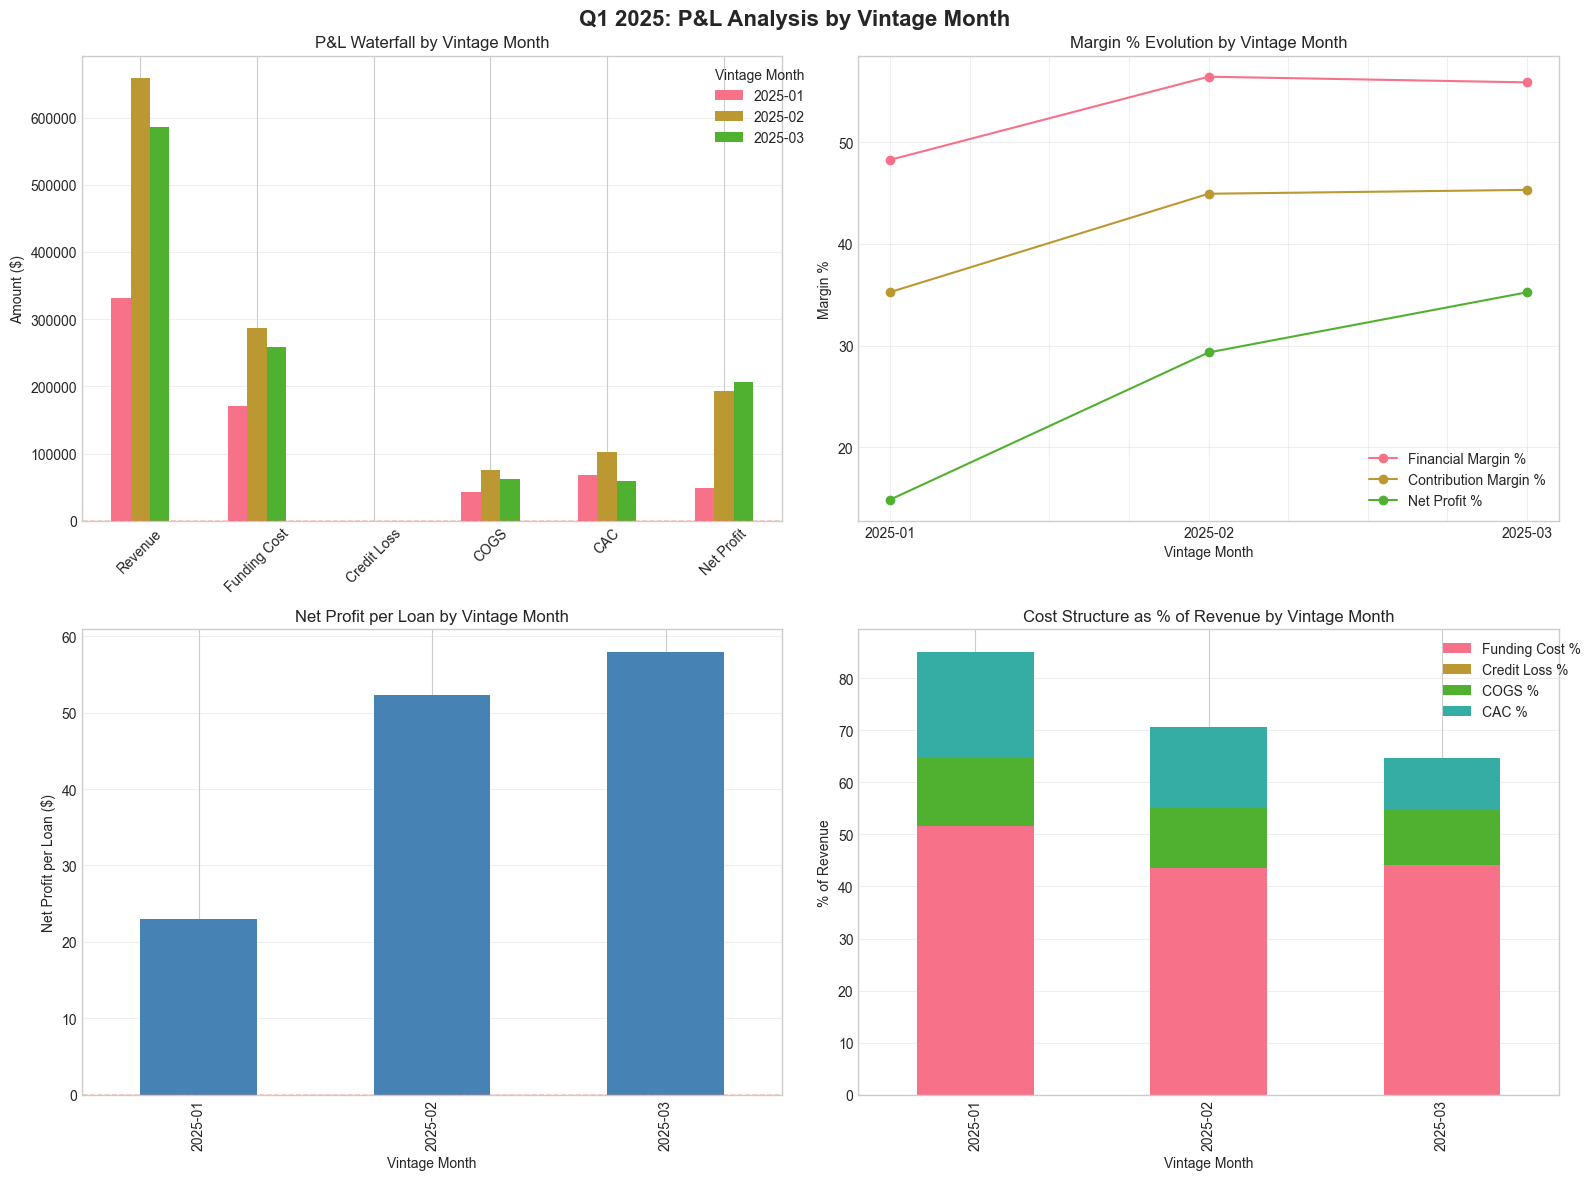


✅ P&L Waterfall analysis complete


In [ ]:
pnl_by_vintage = df_loans.groupby('vintage_month').agg({
    'loan_id': 'count',
    'user_id': 'nunique',
    'loan_amount': 'sum',
    'revenue': 'sum',
    'interest_revenue': 'sum',
    'fee_revenue': 'sum',
    'penalty_revenue': 'sum',
    'funding_cost': 'sum',
    'credit_loss': 'sum',
    'financial_margin': 'sum',
    'cogs': 'sum',
    'contribution_margin': 'sum',
    'cac': 'sum',
    'net_profit': 'sum'
}).round(2)

pnl_by_vintage.columns = [
    '# Loans',
    '# Customers',
    'Loan Amount',
    'Revenue',
    'Interest Revenue',
    'Fee Revenue',
    'Penalty Revenue',
    'Funding Cost',
    'Credit Loss',
    'Financial Margin',
    'COGS',
    'Contribution Margin',
    'CAC',
    'Net Profit'
]

# Agregar métricas calculadas
pnl_by_vintage['Financial Margin %'] = (pnl_by_vintage['Financial Margin'] / pnl_by_vintage['Revenue'] * 100).round(2)
pnl_by_vintage['Contribution Margin %'] = (pnl_by_vintage['Contribution Margin'] / pnl_by_vintage['Revenue'] * 100).round(2)
pnl_by_vintage['Net Profit %'] = (pnl_by_vintage['Net Profit'] / pnl_by_vintage['Revenue'] * 100).round(2)
pnl_by_vintage['Net Profit per Loan'] = (pnl_by_vintage['Net Profit'] / pnl_by_vintage['# Loans']).round(2)

print("\n" + "="*70)
print("P&L WATERFALL BY VINTAGE MONTH - Q1 2025")
print("="*70)
print(pnl_by_vintage)
print("="*70)

# Calcular totales Q1
pnl_total = pnl_by_vintage.sum()
pnl_total['Financial Margin %'] = (pnl_total['Financial Margin'] / pnl_total['Revenue'] * 100).round(2)
pnl_total['Contribution Margin %'] = (pnl_total['Contribution Margin'] / pnl_total['Revenue'] * 100).round(2)
pnl_total['Net Profit %'] = (pnl_total['Net Profit'] / pnl_total['Revenue'] * 100).round(2)
pnl_total['Net Profit per Loan'] = (pnl_total['Net Profit'] / pnl_total['# Loans']).round(2)

print("\n" + "="*70)
print("TOTAL Q1 2025 P&L")
print("="*70)
print(f"Total Loans:              {pnl_total['# Loans']:,.0f}")
print(f"Total Customers:          {pnl_total['# Customers']:,.0f}")
print(f"Total Loan Amount:        ${pnl_total['Loan Amount']:,.2f}")
print(f"")
print(f"Revenue:                  ${pnl_total['Revenue']:,.2f}")
print(f"  - Interest:             ${pnl_total['Interest Revenue']:,.2f}")
print(f"  - Fees:                 ${pnl_total['Fee Revenue']:,.2f}")
print(f"  - Penalties:            ${pnl_total['Penalty Revenue']:,.2f}")
print(f"")
print(f"- Funding Cost:           ${pnl_total['Funding Cost']:,.2f}")
print(f"- Credit Loss:            ${pnl_total['Credit Loss']:,.2f}")
print(f"= Financial Margin:       ${pnl_total['Financial Margin']:,.2f} ({pnl_total['Financial Margin %']:.2f}%)")
print(f"")
print(f"- COGS:                   ${pnl_total['COGS']:,.2f}")
print(f"= Contribution Margin:    ${pnl_total['Contribution Margin']:,.2f} ({pnl_total['Contribution Margin %']:.2f}%)")
print(f"")
print(f"- CAC:                    ${pnl_total['CAC']:,.2f}")
print(f"= Net Profit:             ${pnl_total['Net Profit']:,.2f} ({pnl_total['Net Profit %']:.2f}%)")
print(f"")
print(f"Net Profit per Loan:      ${pnl_total['Net Profit per Loan']:,.2f}")
print("="*70)

# Visualización del P&L Waterfall
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Q1 2025: P&L Analysis by Vintage Month', fontsize=16, fontweight='bold')

# 1. P&L Waterfall por mes
ax1 = axes[0, 0]
waterfall_data = pnl_by_vintage[['Revenue', 'Funding Cost', 'Credit Loss', 'COGS', 'CAC', 'Net Profit']]
waterfall_data.T.plot(kind='bar', ax=ax1)
ax1.set_title('P&L Waterfall by Vintage Month')
ax1.set_ylabel('Amount ($)')
ax1.set_xticklabels(['Revenue', 'Funding Cost', 'Credit Loss', 'COGS', 'CAC', 'Net Profit'], rotation=45)
ax1.legend(title='Vintage Month', bbox_to_anchor=(1.05, 1))
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=0, color='red', linestyle='--', linewidth=1)

# 2. Margin Evolution
ax2 = axes[0, 1]
margins = pnl_by_vintage[['Financial Margin %', 'Contribution Margin %', 'Net Profit %']]
margins.plot(kind='line', ax=ax2, marker='o')
ax2.set_title('Margin % Evolution by Vintage Month')
ax2.set_ylabel('Margin %')
ax2.set_xlabel('Vintage Month')
ax2.legend(['Financial Margin %', 'Contribution Margin %', 'Net Profit %'])
ax2.grid(True, alpha=0.3)

# 3. Net Profit per Loan by Month
ax3 = axes[1, 0]
pnl_by_vintage['Net Profit per Loan'].plot(kind='bar', ax=ax3, color='steelblue')
ax3.set_title('Net Profit per Loan by Vintage Month')
ax3.set_ylabel('Net Profit per Loan ($)')
ax3.set_xlabel('Vintage Month')
ax3.grid(axis='y', alpha=0.3)
ax3.axhline(y=0, color='red', linestyle='--', linewidth=1)

# 4. Cost Breakdown as % of Revenue
ax4 = axes[1, 1]
cost_pct = pd.DataFrame({
    'Funding Cost %': (pnl_by_vintage['Funding Cost'] / pnl_by_vintage['Revenue'] * 100),
    'Credit Loss %': (pnl_by_vintage['Credit Loss'] / pnl_by_vintage['Revenue'] * 100),
    'COGS %': (pnl_by_vintage['COGS'] / pnl_by_vintage['Revenue'] * 100),
    'CAC %': (pnl_by_vintage['CAC'] / pnl_by_vintage['Revenue'] * 100)
})
cost_pct.plot(kind='bar', stacked=True, ax=ax4)
ax4.set_title('Cost Structure as % of Revenue by Vintage Month')
ax4.set_ylabel('% of Revenue')
ax4.set_xlabel('Vintage Month')
ax4.legend(bbox_to_anchor=(1.05, 1))
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



# Risk Segments


PROFITABILITY BY RISK SEGMENT - Q1 2025
                       Total Loans  Total Customers  Total Loan Amount  \
risk_segment_customer                                                    
High Risk                     5991             2934       6,129,475.83   
Low Risk                       567              228         737,786.40   
Medium Risk                   2785             1316       3,679,062.67   
Other                            5                2           4,878.44   
Unknown                         48               20          63,975.26   

                           Revenue  Funding Cost  Credit Loss  \
risk_segment_customer                                           
High Risk             1,041,582.81    439,808.35         0.00   
Low Risk                 45,392.60     33,674.02         0.00   
Medium Risk             480,328.22    238,563.98         0.00   
Other                       770.65        225.15         0.00   
Unknown                   8,187.99      4,351.71  

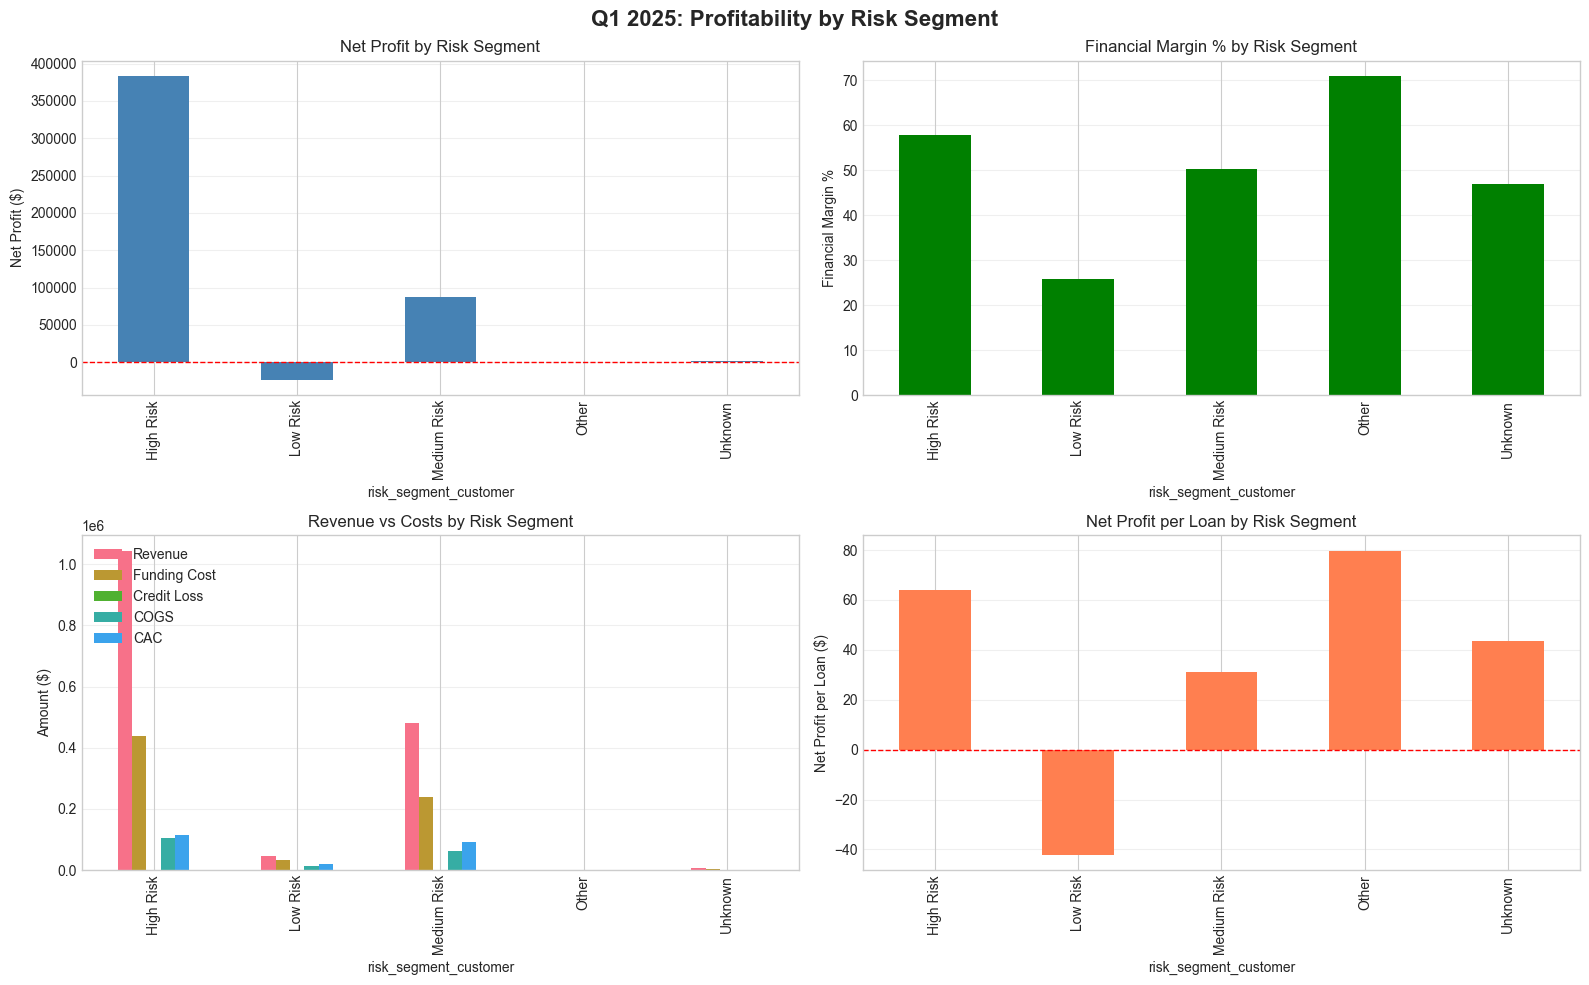


✅ Risk Segment analysis complete


In [ ]:

risk_summary = df_loans.groupby('risk_segment_customer').agg({
    'loan_id': 'count',
    'user_id': 'nunique',
    'loan_amount': 'sum',
    'revenue': 'sum',
    'funding_cost': 'sum',
    'credit_loss': 'sum',
    'financial_margin': 'sum',
    'cogs': 'sum',
    'contribution_margin': 'sum',
    'cac': 'sum',
    'net_profit': 'sum',
    'recovery_rate': 'mean'
}).round(2)

risk_summary.columns = [
    'Total Loans',
    'Total Customers', 
    'Total Loan Amount',
    'Revenue',
    'Funding Cost',
    'Credit Loss',
    'Financial Margin',
    'COGS',
    'Contribution Margin',
    'CAC',
    'Net Profit',
    'Avg Recovery Rate'
]

# Calcular métricas adicionales
risk_summary['Revenue per Loan'] = risk_summary['Revenue'] / risk_summary['Total Loans']
risk_summary['Net Profit per Loan'] = risk_summary['Net Profit'] / risk_summary['Total Loans']
risk_summary['Financial Margin %'] = (risk_summary['Financial Margin'] / risk_summary['Revenue'] * 100).round(2)
risk_summary['Net Profit %'] = (risk_summary['Net Profit'] / risk_summary['Revenue'] * 100).round(2)

print("\n" + "="*70)
print("PROFITABILITY BY RISK SEGMENT - Q1 2025")
print("="*70)
print(risk_summary)
print("="*70)

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Q1 2025: Profitability by Risk Segment', fontsize=16, fontweight='bold')

# 1. Net Profit by Risk Segment
ax1 = axes[0, 0]
risk_summary['Net Profit'].plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Net Profit by Risk Segment')
ax1.set_ylabel('Net Profit ($)')
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=0, color='red', linestyle='--', linewidth=1)

# 2. Financial Margin % by Risk Segment
ax2 = axes[0, 1]
risk_summary['Financial Margin %'].plot(kind='bar', ax=ax2, color='green')
ax2.set_title('Financial Margin % by Risk Segment')
ax2.set_ylabel('Financial Margin %')
ax2.grid(axis='y', alpha=0.3)

# 3. Revenue vs Costs by Risk Segment
ax3 = axes[1, 0]
risk_costs = risk_summary[['Revenue', 'Funding Cost', 'Credit Loss', 'COGS', 'CAC']]
risk_costs.plot(kind='bar', ax=ax3)
ax3.set_title('Revenue vs Costs by Risk Segment')
ax3.set_ylabel('Amount ($)')
ax3.legend(loc='upper left')
ax3.grid(axis='y', alpha=0.3)

# 4. Net Profit per Loan by Risk Segment
ax4 = axes[1, 1]
risk_summary['Net Profit per Loan'].plot(kind='bar', ax=ax4, color='coral')
ax4.set_title('Net Profit per Loan by Risk Segment')
ax4.set_ylabel('Net Profit per Loan ($)')
ax4.grid(axis='y', alpha=0.3)
ax4.axhline(y=0, color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()


# ANALYSIS BY RISK SEGMENT + VINTAGE MONTH


PROFITABILITY BY RISK SEGMENT + VINTAGE MONTH
                                     Loans  Customers  Loan Amount    Revenue  \
vintage_month risk_segment_customer                                             
2025-01       High Risk               1457        988 1,537,614.69 227,167.06   
              Low Risk                 103         77   133,186.86   7,740.43   
              Medium Risk              571        430   809,875.17  94,137.53   
              Other                      1          1       549.50      55.92   
              Unknown                    8          4    13,417.66   1,610.39   
2025-02       High Risk               2368       1579 2,489,345.27 436,285.98   
              Low Risk                 224        147   254,984.15  15,354.68   
              Medium Risk             1080        757 1,480,776.71 203,025.01   
              Other                      4          2     4,328.94     714.73   
              Unknown                   18         13    31,02

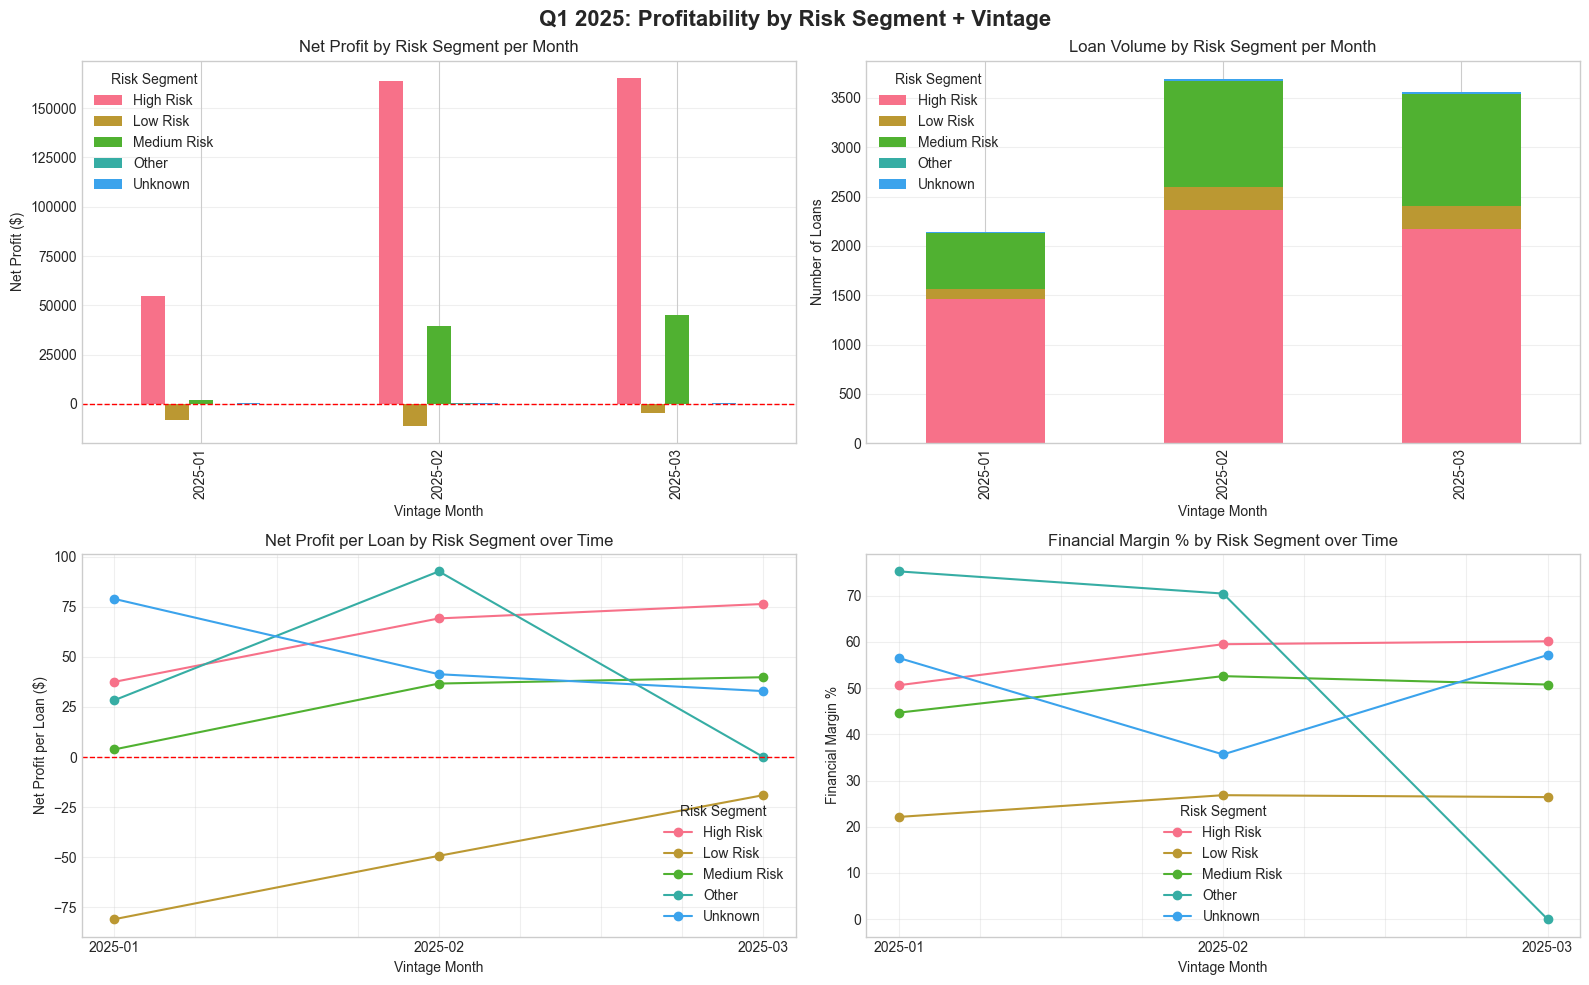


✅ Risk Segment + Vintage analysis complete


In [ ]:

# Resumen por risk segment y vintage month
risk_vintage = df_loans.groupby(['vintage_month', 'risk_segment_customer']).agg({
    'loan_id': 'count',
    'user_id': 'nunique',
    'loan_amount': 'sum',
    'revenue': 'sum',
    'funding_cost': 'sum',
    'credit_loss': 'sum',
    'financial_margin': 'sum',
    'cogs': 'sum',
    'contribution_margin': 'sum',
    'cac': 'sum',
    'net_profit': 'sum',
    'recovery_rate': 'mean'
}).round(2)

risk_vintage.columns = [
    'Loans',
    'Customers', 
    'Loan Amount',
    'Revenue',
    'Funding Cost',
    'Credit Loss',
    'Financial Margin',
    'COGS',
    'Contribution Margin',
    'CAC',
    'Net Profit',
    'Recovery Rate'
]

print("\n" + "="*70)
print("PROFITABILITY BY RISK SEGMENT + VINTAGE MONTH")
print("="*70)
print(risk_vintage)
print("="*70)

# Pivot para visualización
pivot_net_profit = df_loans.pivot_table(
    index='risk_segment_customer',
    columns='vintage_month',
    values='net_profit',
    aggfunc='sum'
).fillna(0)

pivot_loans = df_loans.pivot_table(
    index='risk_segment_customer',
    columns='vintage_month',
    values='loan_id',
    aggfunc='count'
).fillna(0)

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Q1 2025: Profitability by Risk Segment + Vintage', fontsize=16, fontweight='bold')

# 1. Net Profit by Risk Segment and Month
ax1 = axes[0, 0]
pivot_net_profit.T.plot(kind='bar', ax=ax1)
ax1.set_title('Net Profit by Risk Segment per Month')
ax1.set_ylabel('Net Profit ($)')
ax1.set_xlabel('Vintage Month')
ax1.legend(title='Risk Segment', loc='upper left')
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=0, color='red', linestyle='--', linewidth=1)

# 2. Volume by Risk Segment and Month
ax2 = axes[0, 1]
pivot_loans.T.plot(kind='bar', ax=ax2, stacked=True)
ax2.set_title('Loan Volume by Risk Segment per Month')
ax2.set_ylabel('Number of Loans')
ax2.set_xlabel('Vintage Month')
ax2.legend(title='Risk Segment', loc='upper left')
ax2.grid(axis='y', alpha=0.3)

# 3. Net Profit per Loan by Risk Segment over time
ax3 = axes[1, 0]
profit_per_loan = (pivot_net_profit / pivot_loans).fillna(0)
profit_per_loan.T.plot(kind='line', ax=ax3, marker='o')
ax3.set_title('Net Profit per Loan by Risk Segment over Time')
ax3.set_ylabel('Net Profit per Loan ($)')
ax3.set_xlabel('Vintage Month')
ax3.legend(title='Risk Segment')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='red', linestyle='--', linewidth=1)

# 4. Financial Margin % by Risk Segment over time
ax4 = axes[1, 1]
pivot_revenue = df_loans.pivot_table(
    index='risk_segment_customer',
    columns='vintage_month',
    values='revenue',
    aggfunc='sum'
).fillna(0)
pivot_fin_margin = df_loans.pivot_table(
    index='risk_segment_customer',
    columns='vintage_month',
    values='financial_margin',
    aggfunc='sum'
).fillna(0)
margin_pct = (pivot_fin_margin / pivot_revenue * 100).fillna(0)
margin_pct.T.plot(kind='line', ax=ax4, marker='o')
ax4.set_title('Financial Margin % by Risk Segment over Time')
ax4.set_ylabel('Financial Margin %')
ax4.set_xlabel('Vintage Month')
ax4.legend(title='Risk Segment')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



# Recurrent or First Loan


PROFITABILITY: FIRST LOAN vs RECURRENT CUSTOMERS
            Loans  Customers  Loan Amount      Revenue  Funding Cost  \
First Loan   1441       1441 1,950,097.17   270,796.16    137,142.13   
Recurrent    7955       3059 8,665,081.43 1,305,466.11    579,481.07   

            Credit Loss  Financial Margin       COGS  Contribution Margin  \
First Loan         0.00        133,654.03  34,865.40            98,788.63   
Recurrent          0.00        725,985.04 146,177.70           579,807.34   

                  CAC  Net Profit  Recovery Rate  Revenue per Loan  \
First Loan  80,183.82   18,604.81           0.60            187.92   
Recurrent  149,403.07  430,404.27           0.86            164.11   

            Net Profit per Loan  CAC per Loan  Financial Margin %  
First Loan                12.91         55.64               49.36  
Recurrent                 54.10         18.78               55.61  


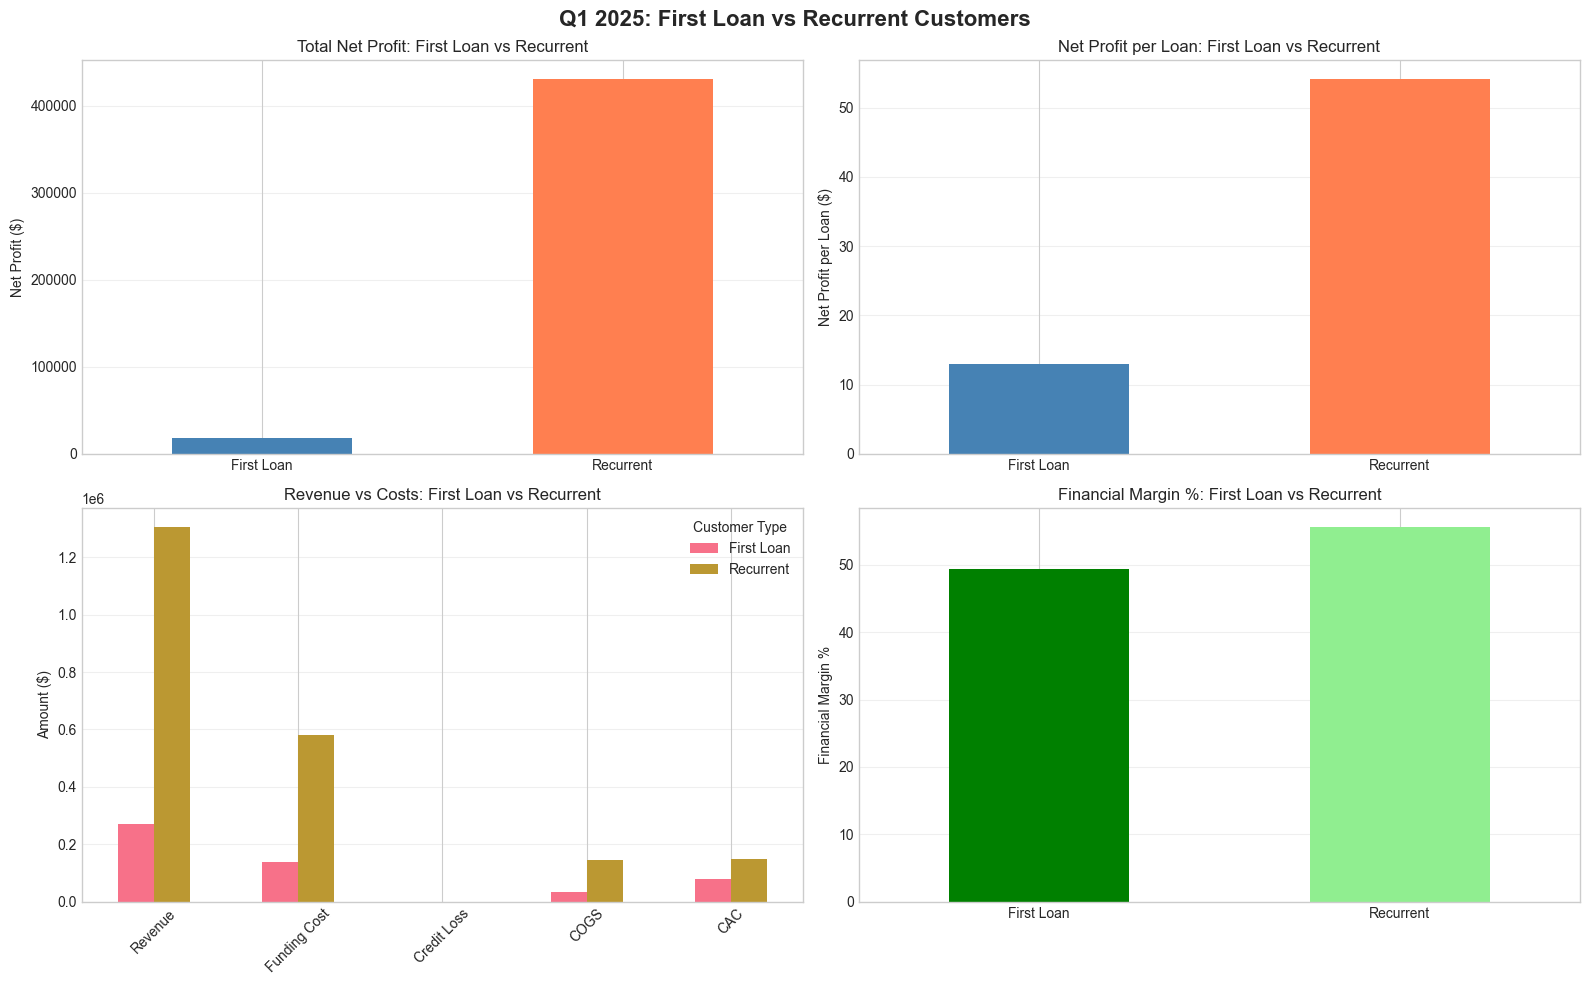

In [10]:
# ============================================================================
# ANALYSIS BY CUSTOMER TYPE (First Loan vs Recurrent)
# ============================================================================

# Resumen por customer type
customer_type = df_loans.groupby('flg_recurrent_customer').agg({
    'loan_id': 'count',
    'user_id': 'nunique',
    'loan_amount': 'sum',
    'revenue': 'sum',
    'funding_cost': 'sum',
    'credit_loss': 'sum',
    'financial_margin': 'sum',
    'cogs': 'sum',
    'contribution_margin': 'sum',
    'cac': 'sum',
    'net_profit': 'sum',
    'recovery_rate': 'mean'
}).round(2)

customer_type.index = ['First Loan', 'Recurrent']
customer_type.columns = [
    'Loans',
    'Customers', 
    'Loan Amount',
    'Revenue',
    'Funding Cost',
    'Credit Loss',
    'Financial Margin',
    'COGS',
    'Contribution Margin',
    'CAC',
    'Net Profit',
    'Recovery Rate'
]

# Métricas por préstamo
customer_type['Revenue per Loan'] = customer_type['Revenue'] / customer_type['Loans']
customer_type['Net Profit per Loan'] = customer_type['Net Profit'] / customer_type['Loans']
customer_type['CAC per Loan'] = customer_type['CAC'] / customer_type['Loans']
customer_type['Financial Margin %'] = (customer_type['Financial Margin'] / customer_type['Revenue'] * 100).round(2)

print("\n" + "="*70)
print("PROFITABILITY: FIRST LOAN vs RECURRENT CUSTOMERS")
print("="*70)
print(customer_type)
print("="*70)

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Q1 2025: First Loan vs Recurrent Customers', fontsize=16, fontweight='bold')

# 1. Net Profit comparison
ax1 = axes[0, 0]
customer_type['Net Profit'].plot(kind='bar', ax=ax1, color=['steelblue', 'coral'])
ax1.set_title('Total Net Profit: First Loan vs Recurrent')
ax1.set_ylabel('Net Profit ($)')
ax1.set_xticklabels(customer_type.index, rotation=0)
ax1.grid(axis='y', alpha=0.3)

# 2. Net Profit per Loan
ax2 = axes[0, 1]
customer_type['Net Profit per Loan'].plot(kind='bar', ax=ax2, color=['steelblue', 'coral'])
ax2.set_title('Net Profit per Loan: First Loan vs Recurrent')
ax2.set_ylabel('Net Profit per Loan ($)')
ax2.set_xticklabels(customer_type.index, rotation=0)
ax2.grid(axis='y', alpha=0.3)

# 3. Revenue vs Costs waterfall
ax3 = axes[1, 0]
costs = customer_type[['Revenue', 'Funding Cost', 'Credit Loss', 'COGS', 'CAC']]
costs.T.plot(kind='bar', ax=ax3)
ax3.set_title('Revenue vs Costs: First Loan vs Recurrent')
ax3.set_ylabel('Amount ($)')
ax3.set_xticklabels(['Revenue', 'Funding Cost', 'Credit Loss', 'COGS', 'CAC'], rotation=45)
ax3.legend(title='Customer Type')
ax3.grid(axis='y', alpha=0.3)

# 4. Financial Margin %
ax4 = axes[1, 1]
customer_type['Financial Margin %'].plot(kind='bar', ax=ax4, color=['green', 'lightgreen'])
ax4.set_title('Financial Margin %: First Loan vs Recurrent')
ax4.set_ylabel('Financial Margin %')
ax4.set_xticklabels(customer_type.index, rotation=0)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()




# COMBINED ANALYSIS: RISK SEGMENT + CUSTOMER TYPE


PROFITABILITY MATRIX: RISK SEGMENT x CUSTOMER TYPE
                                     Loans    Revenue  Net Profit  \
risk_segment_customer customer_type                                 
High Risk             First Loan      1139 226,983.59   56,645.96   
                      Recurrent       4852 814,599.22  326,955.85   
Low Risk              Recurrent        567  45,392.60  -23,942.61   
Medium Risk           First Loan       302  43,812.57  -38,041.15   
                      Recurrent       2483 436,515.65  124,894.95   
Other                 Recurrent          5     770.65      398.68   
Unknown               Recurrent         48   8,187.99    2,097.41   

                                     Net Profit per Loan  Financial Margin %  
risk_segment_customer customer_type                                           
High Risk             First Loan                   49.73               54.22  
                      Recurrent                    67.39               58.77  
Low Risk  

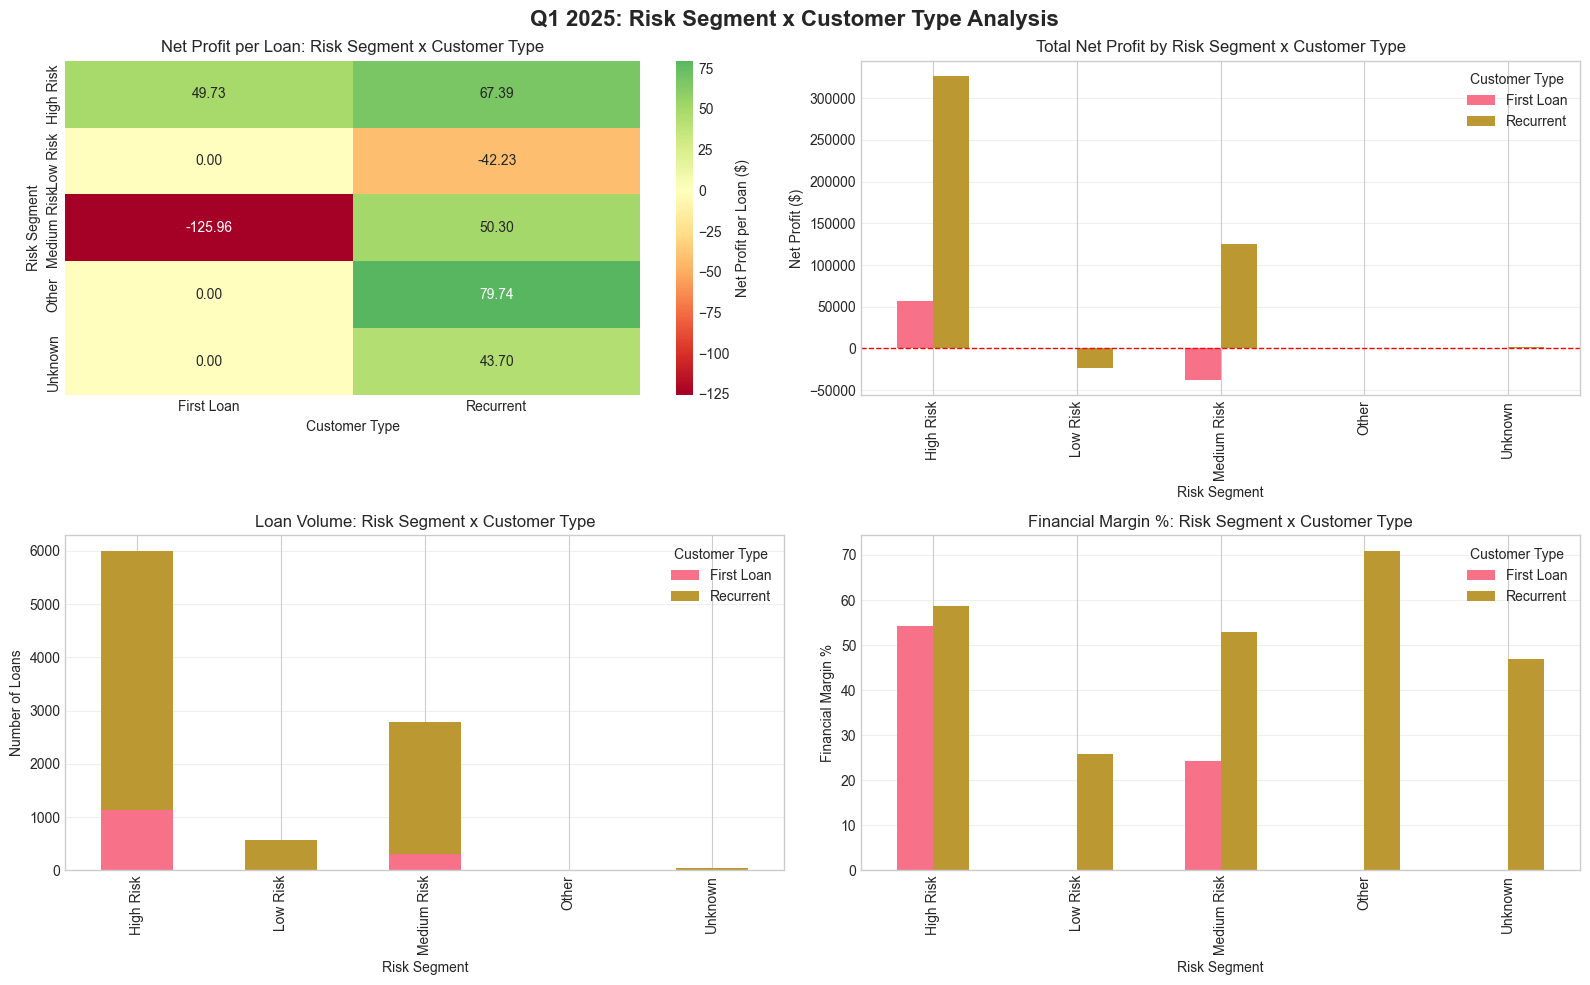


✅ Combined Risk Segment x Customer Type analysis complete


In [ ]:


# Crear label más claro
df_loans['customer_type'] = df_loans['flg_recurrent_customer'].map({
    0: 'First Loan',
    1: 'Recurrent'
})

# Resumen combinado
combined = df_loans.groupby(['risk_segment_customer', 'customer_type']).agg({
    'loan_id': 'count',
    'user_id': 'nunique',
    'loan_amount': 'sum',
    'revenue': 'sum',
    'funding_cost': 'sum',
    'credit_loss': 'sum',
    'financial_margin': 'sum',
    'cogs': 'sum',
    'contribution_margin': 'sum',
    'cac': 'sum',
    'net_profit': 'sum'
}).round(2)

combined.columns = [
    'Loans', 'Customers', 'Loan Amount', 'Revenue',
    'Funding Cost', 'Credit Loss', 'Financial Margin',
    'COGS', 'Contribution Margin', 'CAC', 'Net Profit'
]

# Métricas por préstamo
combined['Net Profit per Loan'] = (combined['Net Profit'] / combined['Loans']).round(2)
combined['Financial Margin %'] = (combined['Financial Margin'] / combined['Revenue'] * 100).round(2)

print("\n" + "="*70)
print("PROFITABILITY MATRIX: RISK SEGMENT x CUSTOMER TYPE")
print("="*70)
print(combined[['Loans', 'Revenue', 'Net Profit', 'Net Profit per Loan', 'Financial Margin %']])
print("="*70)

# Pivot para heatmap
pivot_profit_per_loan = df_loans.pivot_table(
    index='risk_segment_customer',
    columns='customer_type',
    values='net_profit',
    aggfunc='sum'
)
pivot_loans_count = df_loans.pivot_table(
    index='risk_segment_customer',
    columns='customer_type',
    values='loan_id',
    aggfunc='count'
)
profit_per_loan_matrix = (pivot_profit_per_loan / pivot_loans_count).fillna(0)

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Q1 2025: Risk Segment x Customer Type Analysis', fontsize=16, fontweight='bold')

# 1. Net Profit per Loan - Heatmap
ax1 = axes[0, 0]
sns.heatmap(profit_per_loan_matrix, annot=True, fmt='.2f', cmap='RdYlGn', 
            center=0, ax=ax1, cbar_kws={'label': 'Net Profit per Loan ($)'})
ax1.set_title('Net Profit per Loan: Risk Segment x Customer Type')
ax1.set_xlabel('Customer Type')
ax1.set_ylabel('Risk Segment')

# 2. Total Net Profit by combination
ax2 = axes[0, 1]
pivot_profit_per_loan.plot(kind='bar', ax=ax2)
ax2.set_title('Total Net Profit by Risk Segment x Customer Type')
ax2.set_ylabel('Net Profit ($)')
ax2.set_xlabel('Risk Segment')
ax2.legend(title='Customer Type')
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1)

# 3. Volume distribution
ax3 = axes[1, 0]
pivot_loans_count.plot(kind='bar', ax=ax3, stacked=True)
ax3.set_title('Loan Volume: Risk Segment x Customer Type')
ax3.set_ylabel('Number of Loans')
ax3.set_xlabel('Risk Segment')
ax3.legend(title='Customer Type')
ax3.grid(axis='y', alpha=0.3)

# 4. Financial Margin % comparison
ax4 = axes[1, 1]
pivot_revenue = df_loans.pivot_table(
    index='risk_segment_customer',
    columns='customer_type',
    values='revenue',
    aggfunc='sum'
)
pivot_fin_margin = df_loans.pivot_table(
    index='risk_segment_customer',
    columns='customer_type',
    values='financial_margin',
    aggfunc='sum'
)
margin_pct = (pivot_fin_margin / pivot_revenue * 100).fillna(0)
margin_pct.plot(kind='bar', ax=ax4)
ax4.set_title('Financial Margin %: Risk Segment x Customer Type')
ax4.set_ylabel('Financial Margin %')
ax4.set_xlabel('Risk Segment')
ax4.legend(title='Customer Type')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


# VINTAGE CURVES ANALYSIS


VINTAGE CURVES DATA LOADED
Records: 99
Vintages: 3
Risk Segments: 5
Max months tracked: 11

Cohort Sizes (Month 0):
vintage_month risk_segment_customer  total_loans_in_cohort
      2025-01             High Risk                    579
      2025-01              Low Risk                     72
      2025-01           Medium Risk                    354
      2025-01                 Other                      1
      2025-01               Unknown                      4
      2025-02             High Risk                   1132
      2025-02              Low Risk                    156
      2025-02           Medium Risk                    724
      2025-02                 Other                      4
      2025-02               Unknown                     13
      2025-03             High Risk                   1234
      2025-03              Low Risk                    182
      2025-03           Medium Risk                    802
      2025-03               Unknown                     1

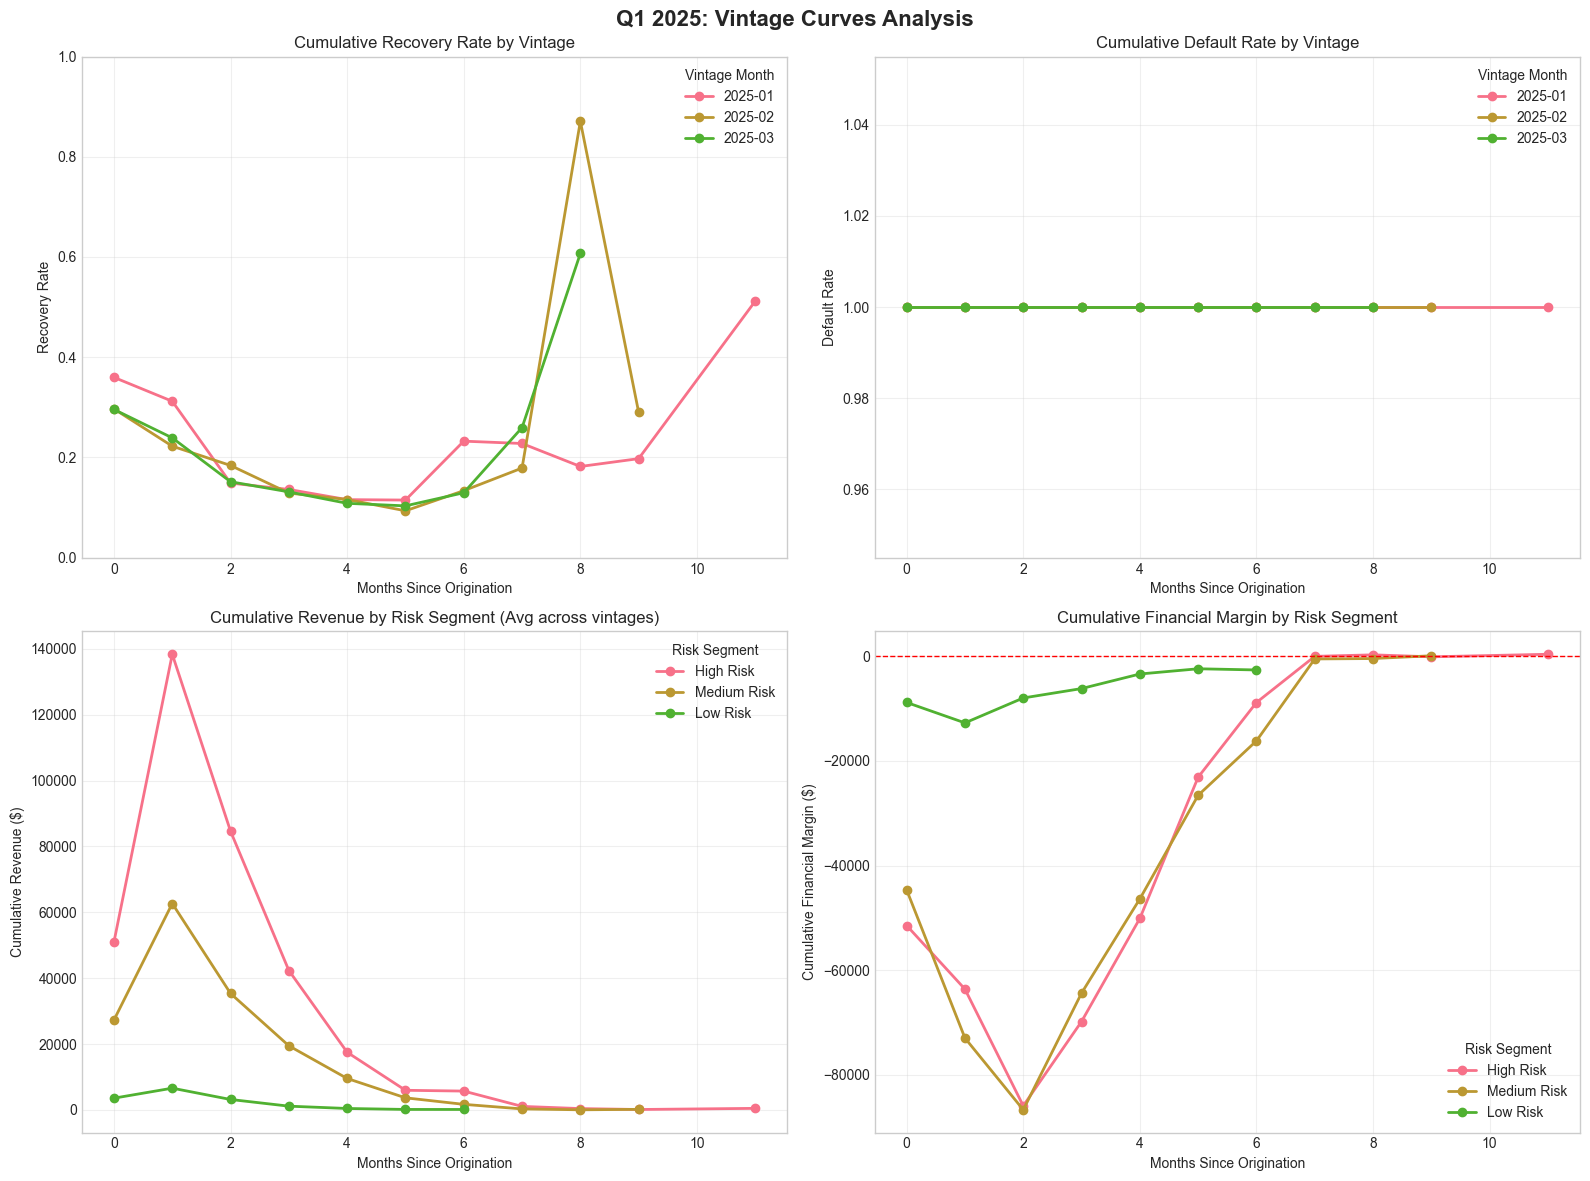


✅ Vintage curves analysis complete


In [ ]:


# Cargar datos de vintage curves
query_vintage = """
SELECT 
    vintage_month,
    risk_segment_customer,
    months_since_origination,
    total_loans_in_cohort,
    cumulative_principal_repaid,
    cumulative_defaults,
    cumulative_revenue,
    cumulative_financial_margin,
    cumulative_recovery_rate,
    cumulative_default_rate
FROM main.mart_vintage_curves
WHERE vintage_month IN ('2025-01', '2025-02', '2025-03')
ORDER BY vintage_month, risk_segment_customer, months_since_origination
"""

df_vintage = conn.execute(query_vintage).df()

print("\n" + "="*70)
print("VINTAGE CURVES DATA LOADED")
print("="*70)
print(f"Records: {len(df_vintage):,}")
print(f"Vintages: {df_vintage['vintage_month'].nunique()}")
print(f"Risk Segments: {df_vintage['risk_segment_customer'].nunique()}")
print(f"Max months tracked: {df_vintage['months_since_origination'].max()}")
print("="*70)

# Mostrar datos por vintage y risk segment en mes 0
print("\nCohort Sizes (Month 0):")
cohort_sizes = df_vintage[df_vintage['months_since_origination'] == 0][
    ['vintage_month', 'risk_segment_customer', 'total_loans_in_cohort']
].sort_values(['vintage_month', 'risk_segment_customer'])
print(cohort_sizes.to_string(index=False))

# Visualización de Vintage Curves
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Q1 2025: Vintage Curves Analysis', fontsize=16, fontweight='bold')

# 1. Cumulative Recovery Rate by Vintage
ax1 = axes[0, 0]
for vintage in sorted(df_vintage['vintage_month'].unique()):
    data = df_vintage[df_vintage['vintage_month'] == vintage].groupby('months_since_origination')['cumulative_recovery_rate'].mean()
    ax1.plot(data.index, data.values, marker='o', label=vintage, linewidth=2)
ax1.set_title('Cumulative Recovery Rate by Vintage')
ax1.set_xlabel('Months Since Origination')
ax1.set_ylabel('Recovery Rate')
ax1.legend(title='Vintage Month')
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# 2. Default Rate Evolution by Vintage
ax2 = axes[0, 1]
for vintage in sorted(df_vintage['vintage_month'].unique()):
    data = df_vintage[df_vintage['vintage_month'] == vintage].groupby('months_since_origination')['cumulative_default_rate'].mean()
    ax2.plot(data.index, data.values, marker='o', label=vintage, linewidth=2)
ax2.set_title('Cumulative Default Rate by Vintage')
ax2.set_xlabel('Months Since Origination')
ax2.set_ylabel('Default Rate')
ax2.legend(title='Vintage Month')
ax2.grid(True, alpha=0.3)

# 3. Cumulative Revenue by Risk Segment (Average across vintages)
ax3 = axes[1, 0]
for risk in ['High Risk', 'Medium Risk', 'Low Risk']:
    if risk in df_vintage['risk_segment_customer'].values:
        data = df_vintage[df_vintage['risk_segment_customer'] == risk].groupby('months_since_origination')['cumulative_revenue'].mean()
        ax3.plot(data.index, data.values, marker='o', label=risk, linewidth=2)
ax3.set_title('Cumulative Revenue by Risk Segment (Avg across vintages)')
ax3.set_xlabel('Months Since Origination')
ax3.set_ylabel('Cumulative Revenue ($)')
ax3.legend(title='Risk Segment')
ax3.grid(True, alpha=0.3)

# 4. Cumulative Financial Margin by Risk Segment
ax4 = axes[1, 1]
for risk in ['High Risk', 'Medium Risk', 'Low Risk']:
    if risk in df_vintage['risk_segment_customer'].values:
        data = df_vintage[df_vintage['risk_segment_customer'] == risk].groupby('months_since_origination')['cumulative_financial_margin'].mean()
        ax4.plot(data.index, data.values, marker='o', label=risk, linewidth=2)
ax4.set_title('Cumulative Financial Margin by Risk Segment')
ax4.set_xlabel('Months Since Origination')
ax4.set_ylabel('Cumulative Financial Margin ($)')
ax4.legend(title='Risk Segment')
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0, color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()



# ============================================================================
# ROLL RATES ANALYSIS (DPD Transitions)
# ============================================================================


In [18]:

# Cargar datos de roll rates
query_rollrates = """
SELECT 
    vintage_month,
    from_bucket,
    to_bucket,
    transition_count,
    roll_rate
FROM main.mart_roll_rates
WHERE vintage_month IN ('2025-01', '2025-02', '2025-03')
ORDER BY vintage_month, from_bucket, to_bucket
"""

df_rollrates = conn.execute(query_rollrates).df()

print("\n" + "="*70)
print("ROLL RATES DATA")
print("="*70)
if len(df_rollrates) > 0:
    print(f"Total transitions: {len(df_rollrates):,}")
    print("\nSample data:")
    print(df_rollrates.head(10))
    print("="*70)
    
    # Crear matriz de transición promedio para Q1
    rollrate_matrix = df_rollrates.pivot_table(
        index='from_bucket',
        columns='to_bucket',
        values='roll_rate',
        aggfunc='mean'
    ).fillna(0)
    
    print("\nAVERAGE ROLL RATE MATRIX - Q1 2025")
    print("="*70)
    print(rollrate_matrix)
    print("="*70)
    
    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Q1 2025: Roll Rates Analysis', fontsize=16, fontweight='bold')
    
    # 1. Roll Rate Heatmap
    ax1 = axes[0]
    sns.heatmap(rollrate_matrix, annot=True, fmt='.2%', cmap='YlOrRd', 
                ax=ax1, cbar_kws={'label': 'Roll Rate'}, vmin=0, vmax=1)
    ax1.set_title('Average Roll Rate Matrix (DPD Transitions)')
    ax1.set_xlabel('To Bucket')
    ax1.set_ylabel('From Bucket')
    
    # 2. Roll Forward Rate by Vintage
    ax2 = axes[1]
    for vintage in sorted(df_rollrates['vintage_month'].unique()):
        vintage_data = df_rollrates[
            (df_rollrates['vintage_month'] == vintage) & 
            (df_rollrates['from_bucket'] != df_rollrates['to_bucket'])
        ].groupby('from_bucket')['roll_rate'].mean()
        if len(vintage_data) > 0:
            ax2.plot(vintage_data.index, vintage_data.values, marker='o', label=vintage, linewidth=2)
    ax2.set_title('Average Roll Forward Rate by Vintage Month')
    ax2.set_xlabel('From DPD Bucket')
    ax2.set_ylabel('Roll Forward Rate')
    ax2.legend(title='Vintage Month')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️  No roll rates data available for Q1 2025")
    print("This could mean:")
    print("  - Loans are too new (no delinquency transitions yet)")
    print("  - All loans are performing (current)")
    print("  - Roll rates table needs to be populated")

print("\n✅ Roll rates analysis complete")

BinderException: Binder Error: Referenced column "from_bucket" not found in FROM clause!
Candidate bindings: "risk_segment_customer", "unknown_count", "loss_rate", "current_count"

LINE 4:     from_bucket,
            ^

# LTV vs CAC ANALYSIS + PAYBACK PERIOD



LTV vs CAC ANALYSIS BY COHORT
                                                            Loans  Customers  \
vintage_month risk_segment_customer flg_recurrent_customer                     
2025-01       High Risk             0                         396        396   
                                    1                        1061        592   
              Low Risk              1                         103         77   
              Medium Risk           0                         105        105   
                                    1                         466        325   
              Other                 1                           1          1   
              Unknown               1                           8          4   
2025-02       High Risk             0                         494        494   
                                    1                        1874       1085   
              Low Risk              1                         224        147   
         

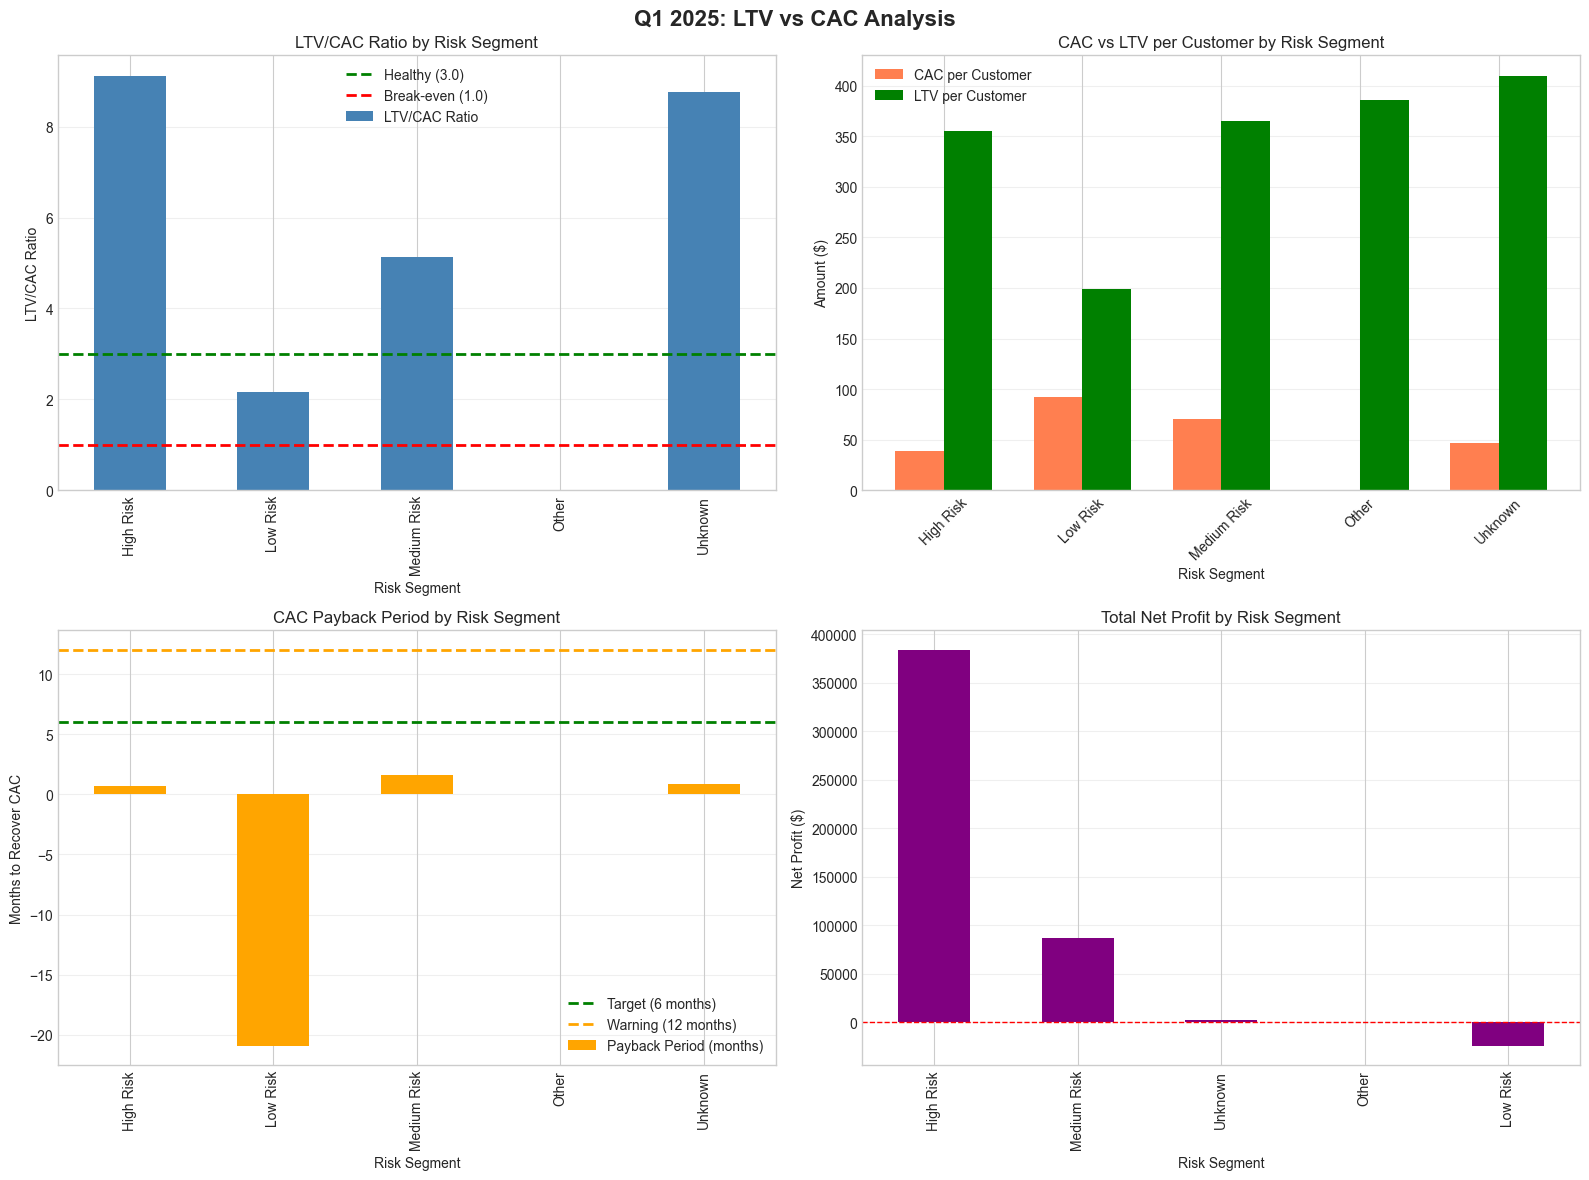


✅ LTV vs CAC analysis complete


In [ ]:


# Calcular LTV por cohort (usamos alñ valor de revenue como proxy de LTV)
ltv_cac_analysis = df_loans.groupby(['vintage_month', 'risk_segment_customer', 'flg_recurrent_customer']).agg({
    'loan_id': 'count',
    'user_id': 'nunique',
    'revenue': 'sum',
    'cac': 'sum',
    'net_profit': 'sum',
    'contribution_margin': 'sum'
}).round(2)

ltv_cac_analysis.columns = [
    'Loans', 'Customers', 'LTV (Revenue)', 'CAC', 'Net Profit', 'Contribution Margin'
]

# Calcular métricas
ltv_cac_analysis['LTV per Customer'] = (ltv_cac_analysis['LTV (Revenue)'] / ltv_cac_analysis['Customers']).round(2)
ltv_cac_analysis['CAC per Customer'] = (ltv_cac_analysis['CAC'] / ltv_cac_analysis['Customers']).round(2)
ltv_cac_analysis['LTV/CAC Ratio'] = (ltv_cac_analysis['LTV per Customer'] / ltv_cac_analysis['CAC per Customer'].replace(0, np.nan)).round(2)
ltv_cac_analysis['Net Profit per Customer'] = (ltv_cac_analysis['Net Profit'] / ltv_cac_analysis['Customers']).round(2)

# Estimar payback period (meses para recuperar CAC)
ltv_cac_analysis['Payback Period (months)'] = (
    ltv_cac_analysis['CAC per Customer'] / 
    (ltv_cac_analysis['Contribution Margin'] / ltv_cac_analysis['Customers'] / 3)  # Dividido por 3 meses
).replace([np.inf, -np.inf], np.nan).round(1)

print("\n" + "="*70)
print("LTV vs CAC ANALYSIS BY COHORT")
print("="*70)
print(ltv_cac_analysis)
print("="*70)

# Resumen por Risk Segment (agregado)
ltv_by_risk = df_loans.groupby(['risk_segment_customer']).agg({
    'user_id': 'nunique',
    'revenue': 'sum',
    'cac': 'sum',
    'contribution_margin': 'sum',
    'net_profit': 'sum'
}).round(2)

ltv_by_risk.columns = ['Customers', 'LTV (Revenue)', 'CAC', 'Contribution Margin', 'Net Profit']
ltv_by_risk['LTV per Customer'] = (ltv_by_risk['LTV (Revenue)'] / ltv_by_risk['Customers']).round(2)
ltv_by_risk['CAC per Customer'] = (ltv_by_risk['CAC'] / ltv_by_risk['Customers']).round(2)
ltv_by_risk['LTV/CAC Ratio'] = (ltv_by_risk['LTV per Customer'] / ltv_by_risk['CAC per Customer'].replace(0, np.nan)).round(2)
ltv_by_risk['Monthly Contribution per Customer'] = (ltv_by_risk['Contribution Margin'] / ltv_by_risk['Customers'] / 3).round(2)
ltv_by_risk['Payback Period (months)'] = (
    ltv_by_risk['CAC per Customer'] / ltv_by_risk['Monthly Contribution per Customer']
).replace([np.inf, -np.inf], np.nan).round(1)

print("\nLTV vs CAC BY RISK SEGMENT (Q1 2025 Aggregate)")
print("="*70)
print(ltv_by_risk)
print("="*70)

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Q1 2025: LTV vs CAC Analysis', fontsize=16, fontweight='bold')

# 1. LTV/CAC Ratio by Risk Segment
ax1 = axes[0, 0]
ltv_by_risk['LTV/CAC Ratio'].plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('LTV/CAC Ratio by Risk Segment')
ax1.set_ylabel('LTV/CAC Ratio')
ax1.set_xlabel('Risk Segment')
ax1.axhline(y=3, color='green', linestyle='--', linewidth=2, label='Healthy (3.0)')
ax1.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Break-even (1.0)')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. CAC vs LTV per Customer
ax2 = axes[0, 1]
x = np.arange(len(ltv_by_risk))
width = 0.35
ax2.bar(x - width/2, ltv_by_risk['CAC per Customer'], width, label='CAC per Customer', color='coral')
ax2.bar(x + width/2, ltv_by_risk['LTV per Customer'], width, label='LTV per Customer', color='green')
ax2.set_title('CAC vs LTV per Customer by Risk Segment')
ax2.set_ylabel('Amount ($)')
ax2.set_xlabel('Risk Segment')
ax2.set_xticks(x)
ax2.set_xticklabels(ltv_by_risk.index, rotation=45)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Payback Period by Risk Segment
ax3 = axes[1, 0]
ltv_by_risk['Payback Period (months)'].plot(kind='bar', ax=ax3, color='orange')
ax3.set_title('CAC Payback Period by Risk Segment')
ax3.set_ylabel('Months to Recover CAC')
ax3.set_xlabel('Risk Segment')
ax3.axhline(y=6, color='green', linestyle='--', linewidth=2, label='Target (6 months)')
ax3.axhline(y=12, color='orange', linestyle='--', linewidth=2, label='Warning (12 months)')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Net Profit per Customer by Risk Segment
ax4 = axes[1, 1]
ltv_by_risk_sorted = ltv_by_risk.sort_values('Net Profit', ascending=False)
ltv_by_risk_sorted['Net Profit'].plot(kind='bar', ax=ax4, color='purple')
ax4.set_title('Total Net Profit by Risk Segment')
ax4.set_ylabel('Net Profit ($)')
ax4.set_xlabel('Risk Segment')
ax4.grid(axis='y', alpha=0.3)
ax4.axhline(y=0, color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

print("\n✅ LTV vs CAC analysis complete")

# LOSS RATES & DELINQUENCY ANALYSIS


LOSS RATES & DELINQUENCY BY RISK SEGMENT
                       Total Loans  Loan Amount  Credit Loss  \
risk_segment_customer                                          
High Risk                     5991 6,129,475.83         0.00   
Low Risk                       567   737,786.40         0.00   
Medium Risk                   2785 3,679,062.67         0.00   
Other                            5     4,878.44         0.00   
Unknown                         48    63,975.26         0.00   

                       Principal Repaid  Avg Recovery Rate  Delinquent Loans  \
risk_segment_customer                                                          
High Risk                  4,438,076.12               0.75                 0   
Low Risk                     714,626.56               0.98                 0   
Medium Risk                3,378,658.79               0.95                 0   
Other                          4,878.44               1.00                 0   
Unknown                      

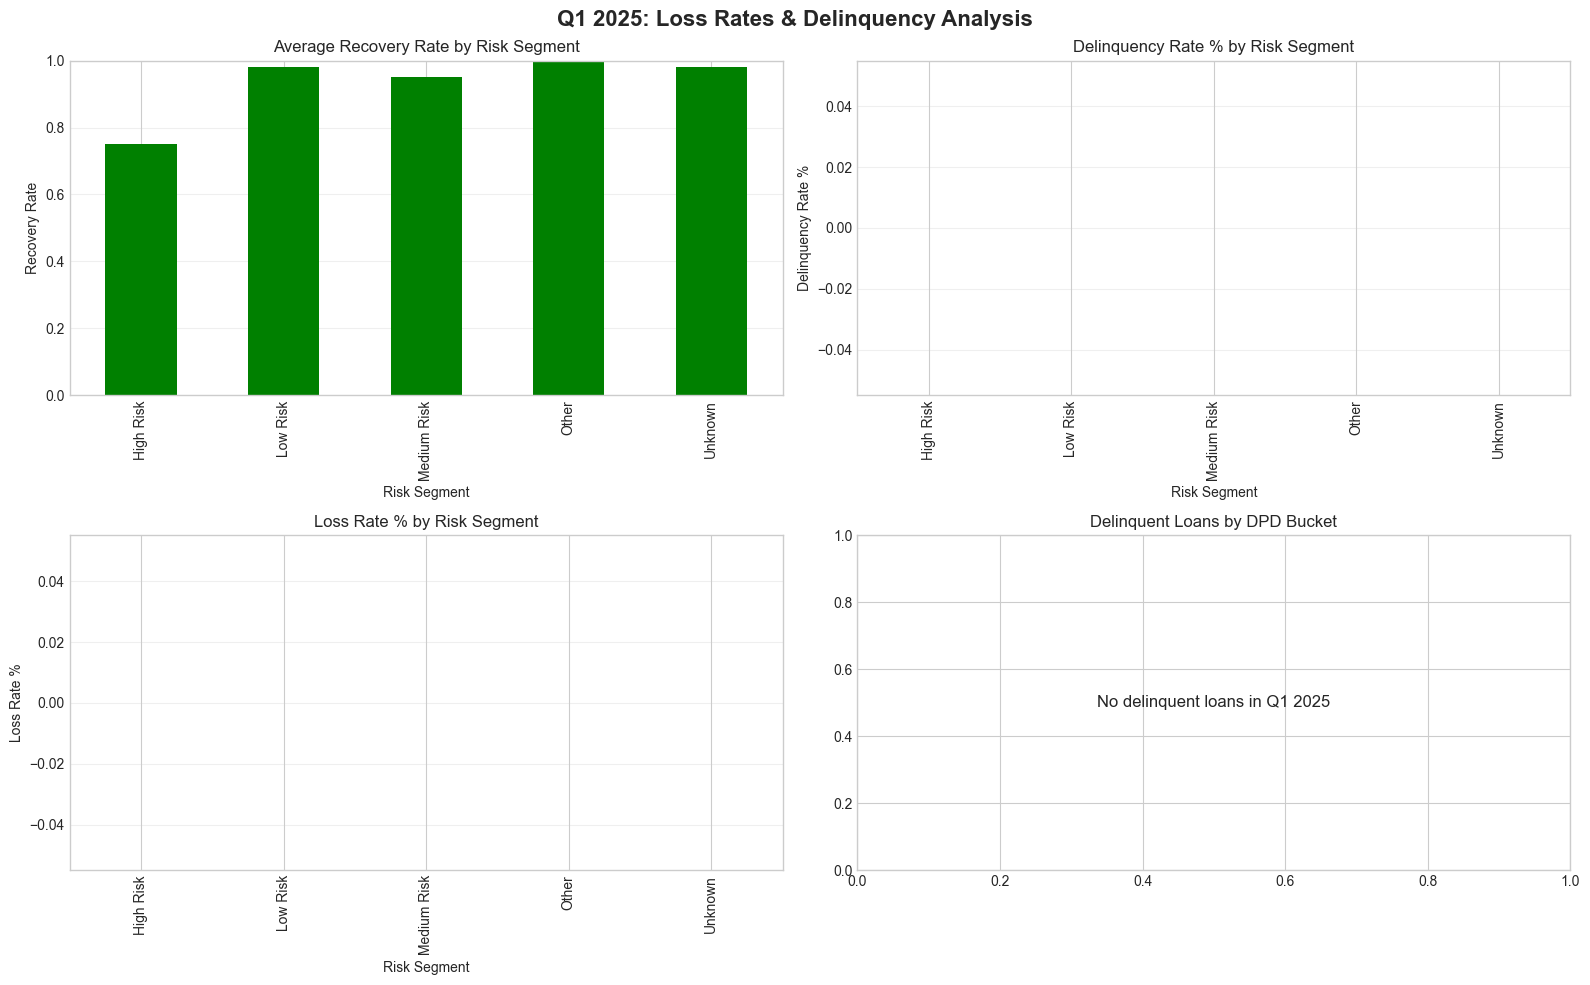


✅ Loss rates & delinquency analysis complete


In [ ]:

# Loss rate por risk segment
loss_analysis = df_loans.groupby('risk_segment_customer').agg({
    'loan_id': 'count',
    'loan_amount': 'sum',
    'credit_loss': 'sum',
    'principal_repaid': 'sum',
    'recovery_rate': 'mean',
    'is_delinquent': 'sum',
    'capital_balance': 'sum'
}).round(2)

loss_analysis.columns = [
    'Total Loans',
    'Loan Amount',
    'Credit Loss',
    'Principal Repaid',
    'Avg Recovery Rate',
    'Delinquent Loans',
    'Outstanding Balance'
]

# Calcular métricas adicionales
loss_analysis['Loss Rate %'] = (loss_analysis['Credit Loss'] / loss_analysis['Loan Amount'] * 100).round(2)
loss_analysis['Repayment Rate %'] = (loss_analysis['Principal Repaid'] / loss_analysis['Loan Amount'] * 100).round(2)
loss_analysis['Delinquency Rate %'] = (loss_analysis['Delinquent Loans'] / loss_analysis['Total Loans'] * 100).round(2)

print("\n" + "="*70)
print("LOSS RATES & DELINQUENCY BY RISK SEGMENT")
print("="*70)
print(loss_analysis)
print("="*70)

# Delinquency por DPD bucket
dpd_analysis = df_loans[df_loans['is_delinquent'] == 1].groupby('dpd_bucket').agg({
    'loan_id': 'count',
    'loan_amount': 'sum',
    'capital_balance': 'sum'
}).round(2)

dpd_analysis.columns = ['Delinquent Loans', 'Original Loan Amount', 'Outstanding Balance']

print("\nDELINQUENCY BY DPD BUCKET")
print("="*70)
print(dpd_analysis)
print("="*70)

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Q1 2025: Loss Rates & Delinquency Analysis', fontsize=16, fontweight='bold')

# 1. Recovery Rate by Risk Segment
ax1 = axes[0, 0]
loss_analysis['Avg Recovery Rate'].plot(kind='bar', ax=ax1, color='green')
ax1.set_title('Average Recovery Rate by Risk Segment')
ax1.set_ylabel('Recovery Rate')
ax1.set_xlabel('Risk Segment')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1])

# 2. Delinquency Rate by Risk Segment
ax2 = axes[0, 1]
loss_analysis['Delinquency Rate %'].plot(kind='bar', ax=ax2, color='red')
ax2.set_title('Delinquency Rate % by Risk Segment')
ax2.set_ylabel('Delinquency Rate %')
ax2.set_xlabel('Risk Segment')
ax2.grid(axis='y', alpha=0.3)

# 3. Loss Rate by Risk Segment
ax3 = axes[1, 0]
loss_analysis['Loss Rate %'].plot(kind='bar', ax=ax3, color='coral')
ax3.set_title('Loss Rate % by Risk Segment')
ax3.set_ylabel('Loss Rate %')
ax3.set_xlabel('Risk Segment')
ax3.grid(axis='y', alpha=0.3)

# 4. Delinquent Loans by DPD Bucket
ax4 = axes[1, 1]
if len(dpd_analysis) > 0:
    dpd_analysis['Delinquent Loans'].plot(kind='bar', ax=ax4, color='orange')
    ax4.set_title('Delinquent Loans by DPD Bucket')
    ax4.set_ylabel('Number of Loans')
    ax4.set_xlabel('DPD Bucket')
    ax4.grid(axis='y', alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'No delinquent loans in Q1 2025', 
             ha='center', va='center', fontsize=12)
    ax4.set_title('Delinquent Loans by DPD Bucket')

plt.tight_layout()
plt.show()



PROFITABILITY MATRIX: RISK SEGMENT x CUSTOMER TYPE
                                     Loans    Revenue  Net Profit  \
risk_segment_customer customer_type                                 
High Risk             First Loan      1139 226,983.59   56,645.96   
                      Recurrent       4852 814,599.22  326,955.85   
Low Risk              Recurrent        567  45,392.60  -23,942.61   
Medium Risk           First Loan       302  43,812.57  -38,041.15   
                      Recurrent       2483 436,515.65  124,894.95   
Other                 Recurrent          5     770.65      398.68   
Unknown               Recurrent         48   8,187.99    2,097.41   

                                     Net Profit per Loan  Financial Margin %  
risk_segment_customer customer_type                                           
High Risk             First Loan                   49.73               54.22  
                      Recurrent                    67.39               58.77  
Low Risk  

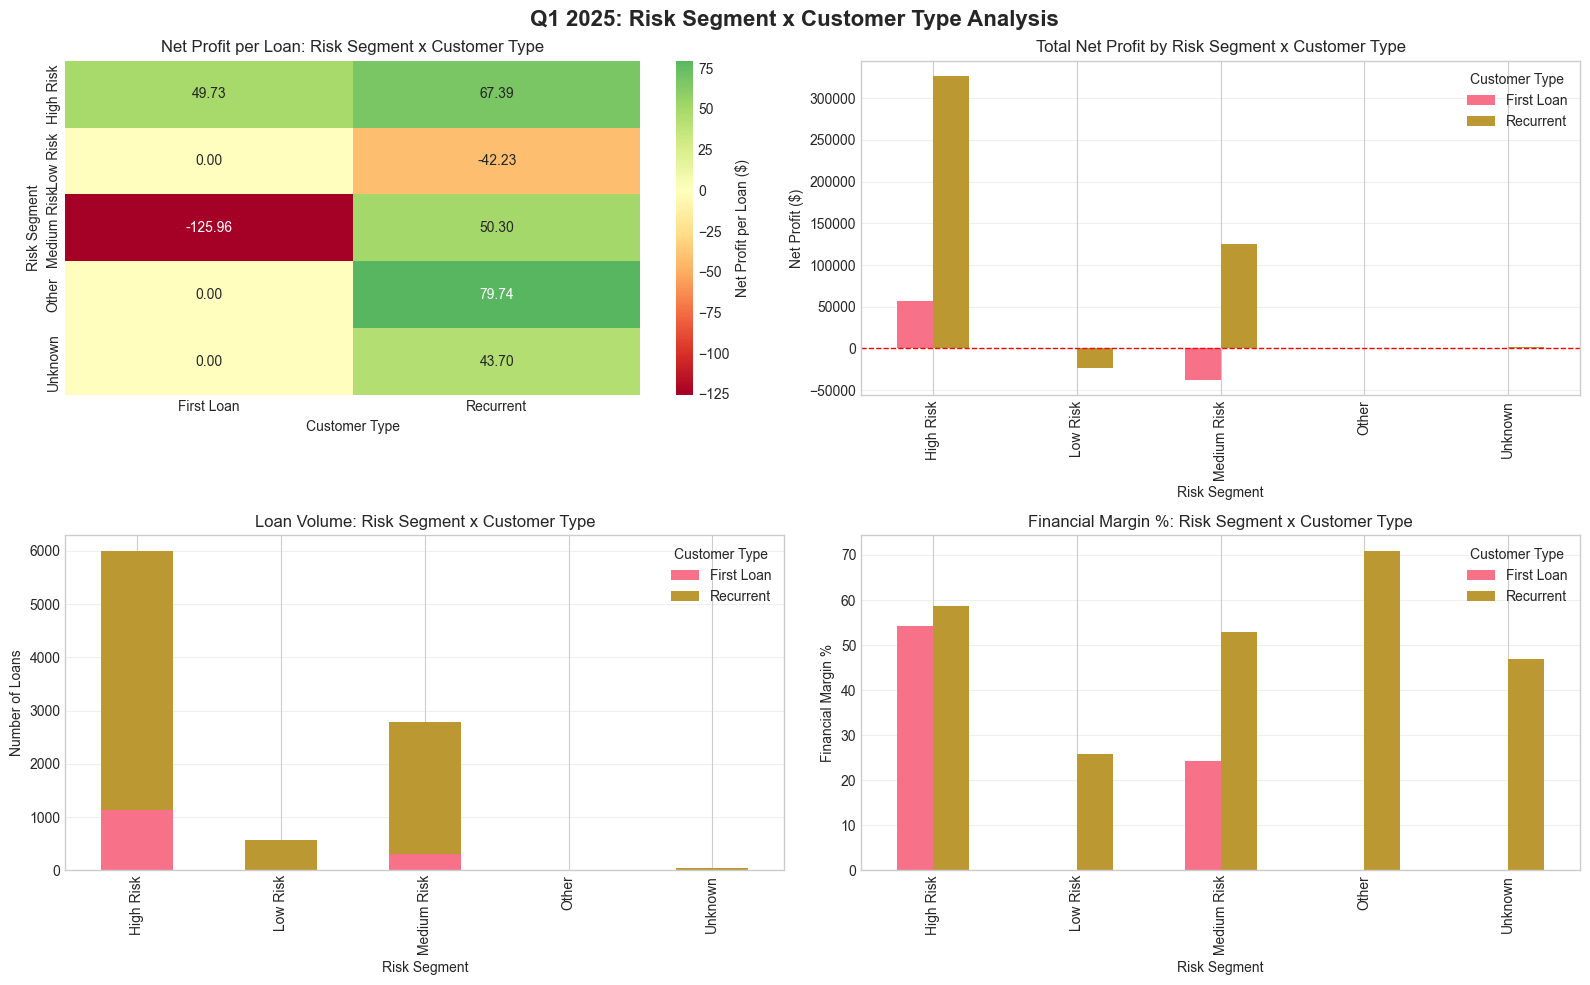


✅ Combined Risk Segment x Customer Type analysis complete


In [11]:


# Crear label más claro
df_loans['customer_type'] = df_loans['flg_recurrent_customer'].map({
    0: 'First Loan',
    1: 'Recurrent'
})

# Resumen combinado
combined = df_loans.groupby(['risk_segment_customer', 'customer_type']).agg({
    'loan_id': 'count',
    'user_id': 'nunique',
    'loan_amount': 'sum',
    'revenue': 'sum',
    'funding_cost': 'sum',
    'credit_loss': 'sum',
    'financial_margin': 'sum',
    'cogs': 'sum',
    'contribution_margin': 'sum',
    'cac': 'sum',
    'net_profit': 'sum'
}).round(2)

combined.columns = [
    'Loans', 'Customers', 'Loan Amount', 'Revenue',
    'Funding Cost', 'Credit Loss', 'Financial Margin',
    'COGS', 'Contribution Margin', 'CAC', 'Net Profit'
]

# Métricas por préstamo
combined['Net Profit per Loan'] = (combined['Net Profit'] / combined['Loans']).round(2)
combined['Financial Margin %'] = (combined['Financial Margin'] / combined['Revenue'] * 100).round(2)

print("\n" + "="*70)
print("PROFITABILITY MATRIX: RISK SEGMENT x CUSTOMER TYPE")
print("="*70)
print(combined[['Loans', 'Revenue', 'Net Profit', 'Net Profit per Loan', 'Financial Margin %']])
print("="*70)

# Pivot para heatmap
pivot_profit_per_loan = df_loans.pivot_table(
    index='risk_segment_customer',
    columns='customer_type',
    values='net_profit',
    aggfunc='sum'
)
pivot_loans_count = df_loans.pivot_table(
    index='risk_segment_customer',
    columns='customer_type',
    values='loan_id',
    aggfunc='count'
)
profit_per_loan_matrix = (pivot_profit_per_loan / pivot_loans_count).fillna(0)

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Q1 2025: Risk Segment x Customer Type Analysis', fontsize=16, fontweight='bold')

# 1. Net Profit per Loan - Heatmap
ax1 = axes[0, 0]
sns.heatmap(profit_per_loan_matrix, annot=True, fmt='.2f', cmap='RdYlGn', 
            center=0, ax=ax1, cbar_kws={'label': 'Net Profit per Loan ($)'})
ax1.set_title('Net Profit per Loan: Risk Segment x Customer Type')
ax1.set_xlabel('Customer Type')
ax1.set_ylabel('Risk Segment')

# 2. Total Net Profit by combination
ax2 = axes[0, 1]
pivot_profit_per_loan.plot(kind='bar', ax=ax2)
ax2.set_title('Total Net Profit by Risk Segment x Customer Type')
ax2.set_ylabel('Net Profit ($)')
ax2.set_xlabel('Risk Segment')
ax2.legend(title='Customer Type')
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1)

# 3. Volume distribution
ax3 = axes[1, 0]
pivot_loans_count.plot(kind='bar', ax=ax3, stacked=True)
ax3.set_title('Loan Volume: Risk Segment x Customer Type')
ax3.set_ylabel('Number of Loans')
ax3.set_xlabel('Risk Segment')
ax3.legend(title='Customer Type')
ax3.grid(axis='y', alpha=0.3)

# 4. Financial Margin % comparison
ax4 = axes[1, 1]
pivot_revenue = df_loans.pivot_table(
    index='risk_segment_customer',
    columns='customer_type',
    values='revenue',
    aggfunc='sum'
)
pivot_fin_margin = df_loans.pivot_table(
    index='risk_segment_customer',
    columns='customer_type',
    values='financial_margin',
    aggfunc='sum'
)
margin_pct = (pivot_fin_margin / pivot_revenue * 100).fillna(0)
margin_pct.plot(kind='bar', ax=ax4)
ax4.set_title('Financial Margin %: Risk Segment x Customer Type')
ax4.set_ylabel('Financial Margin %')
ax4.set_xlabel('Risk Segment')
ax4.legend(title='Customer Type')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Combined Risk Segment x Customer Type analysis complete")

## KPIs PRINCIPALES

In [ ]:
# KPIs Principales por Segmento
query_kpis = """
WITH customer_lifetime AS (
    SELECT 
        l.user_id,
        MAX(l.risk_segment) as risk_segment,
        SUM(l.revenue_total) as lifetime_revenue,
        SUM(l.cac) as total_cac_paid,
        COUNT(DISTINCT l.loan_id) as total_loans
    FROM main.fct_loan_financials l
    WHERE l.risk_segment IN ('High Risk', 'Medium Risk', 'Low Risk')
    GROUP BY l.user_id
)
SELECT 
    risk_segment,
    COUNT(DISTINCT user_id) as customers,
    SUM(total_loans) as loans,
    ROUND(SUM(lifetime_revenue), 0) as total_revenue,
    ROUND(SUM(total_cac_paid), 0) as total_cac,
    ROUND(SUM(lifetime_revenue) / NULLIF(SUM(total_cac_paid), 0), 2) as ltv_to_cac,
    ROUND(AVG(total_loans), 1) as avg_loans_per_customer,
    ROUND(AVG(lifetime_revenue), 0) as avg_ltv,
    ROUND(SUM(lifetime_revenue) / SUM(total_loans), 0) as avg_revenue_per_loan
FROM customer_lifetime
GROUP BY risk_segment
ORDER BY total_revenue DESC
"""

df_kpis = conn.execute(query_kpis).df()

print("="*80)
print("KPIs PRINCIPALES POR SEGMENTO DE RIESGO")
print("="*80)
print(df_kpis.to_string(index=False))

# Totales
print("\n" + "="*80)
print("TOTALES PORTFOLIO Q1 2025")
print("="*80)
print(f"Total Clientes: {df_kpis['customers'].sum():,}")
print(f"Total Préstamos: {df_kpis['loans'].sum():,}")
print(f"Revenue Total: ${df_kpis['total_revenue'].sum():,.0f}")
print(f"CAC Total: ${df_kpis['total_cac'].sum():,.0f}")
print(f"\n⭐ LTV/CAC Promedio Ponderado: {df_kpis['total_revenue'].sum() / df_kpis['total_cac'].sum():.2f}x")

KPIs PRINCIPALES POR SEGMENTO DE RIESGO
risk_segment  customers    loans  total_revenue  total_cac  ltv_to_cac  avg_loans_per_customer  avg_ltv  avg_revenue_per_loan
   High Risk       2934 5,991.00   1,185,249.00 114,298.00       10.37                    2.00   404.00                198.00
 Medium Risk       1316 2,785.00     546,580.00  93,417.00        5.85                    2.10   415.00                196.00
    Low Risk        228   567.00      51,654.00  20,936.00        2.47                    2.50   227.00                 91.00

TOTALES PORTFOLIO Q1 2025
Total Clientes: 4,478
Total Préstamos: 9,343.0
Revenue Total: $1,783,483
CAC Total: $228,651

⭐ LTV/CAC Promedio Ponderado: 7.80x


## 2️⃣ MÉTRICAS DE CAC - NUEVA: CAC POR PRÉSTAMO

In [ ]:
# Métricas a nivel cliente
query_cac_cliente = """
SELECT 
    risk_segment,
    COUNT(*) as customers,
    ROUND(AVG(total_loans), 2) as avg_loans_per_customer,
    ROUND(AVG(cac_total), 2) as avg_cac_total,
    ROUND(AVG(cac_per_loan), 2) as avg_cac_per_loan
FROM main.int_customer_loan_metrics
WHERE risk_segment IN ('High Risk', 'Medium Risk', 'Low Risk')
GROUP BY risk_segment
ORDER BY customers DESC
"""

df_cac_cliente = conn.execute(query_cac_cliente).df()

print("="*80)
print("MÉTRICAS DE CAC A NIVEL CLIENTE")
print("="*80)
print(df_cac_cliente.to_string(index=False))
print("\n�� avg_cac_per_loan = CAC Total / Total Préstamos del Cliente")

# Métricas a nivel préstamo
query_cac_prestamo = """
SELECT 
    loan_sequence_number as prestamo_num,
    COUNT(*) as loans,
    ROUND(AVG(customer_total_loans), 1) as avg_total_loans_cliente,
    ROUND(AVG(customer_cac_per_loan), 2) as avg_cac_per_loan,
    ROUND(SUM(cac), 0) as cac_asignado,
    ROUND(AVG(revenue_total), 0) as avg_revenue
FROM main.fct_loan_financials
WHERE loan_sequence_number <= 5
GROUP BY loan_sequence_number
ORDER BY loan_sequence_number
"""

df_cac_prestamo = conn.execute(query_cac_prestamo).df()

print("\n" + "="*80)
print("MÉTRICAS DE CAC A NIVEL PRÉSTAMO")
print("="*80)
print(df_cac_prestamo.to_string(index=False))
print("\n✅ Verificación: CAC solo se asigna al préstamo #1")

MÉTRICAS DE CAC A NIVEL CLIENTE
risk_segment  customers  avg_loans_per_customer  avg_cac_total  avg_cac_per_loan
   High Risk       2934                    4.68          38.96             21.01
 Medium Risk       1316                    9.24          70.99             37.88
    Low Risk        228                   13.08          91.82             18.23

�� avg_cac_per_loan = CAC Total / Total Préstamos del Cliente

MÉTRICAS DE CAC A NIVEL PRÉSTAMO
 prestamo_num  loans  avg_total_loans_cliente  avg_cac_per_loan  cac_asignado  avg_revenue
            1   4500                     6.50             25.73    229,587.00       227.00
            2   2039                    10.30              8.51          0.00       181.00
            3   1082                    13.90              4.90          0.00       158.00
            4    613                    17.90              3.72          0.00       155.00
            5    367                    21.60              2.46          0.00       147.00



## ��� GRÁFICO 1: LTV/CAC POR SEGMENTO 

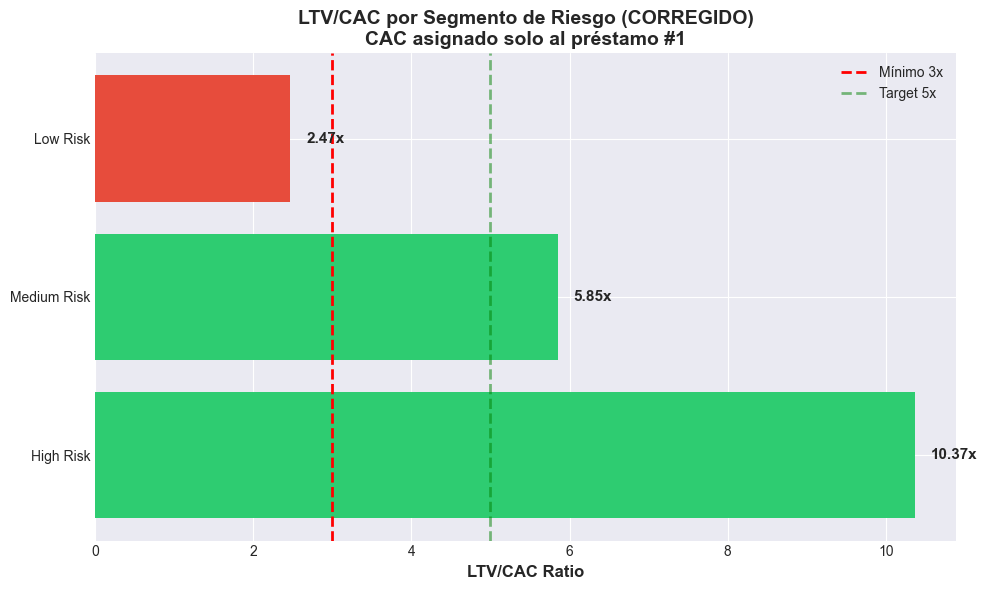

✅ Gráfico guardado: 01_ltv_cac_corregido.png


In [ ]:
# Gráfico LTV/CAC
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#2ecc71' if x >= 5 else '#e74c3c' if x < 3 else '#f39c12' 
          for x in df_kpis['ltv_to_cac']]

bars = ax.barh(df_kpis['risk_segment'], df_kpis['ltv_to_cac'], color=colors)
ax.axvline(x=3, color='red', linestyle='--', linewidth=2, label='Mínimo 3x')
ax.axvline(x=5, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Target 5x')

ax.set_xlabel('LTV/CAC Ratio', fontsize=12, fontweight='bold')
ax.set_title('LTV/CAC por Segmento de Riesgo (CORREGIDO)\nCAC asignado solo al préstamo #1', 
             fontsize=14, fontweight='bold')
ax.legend()

for i, (idx, row) in enumerate(df_kpis.iterrows()):
    ax.text(row['ltv_to_cac'] + 0.2, i, f"{row['ltv_to_cac']:.2f}x", 
            va='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('graficos_finales/01_ltv_cac_corregido.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico guardado: 01_ltv_cac_corregido.png")

## ��� GRÁFICO 2: PORTFOLIO MIX

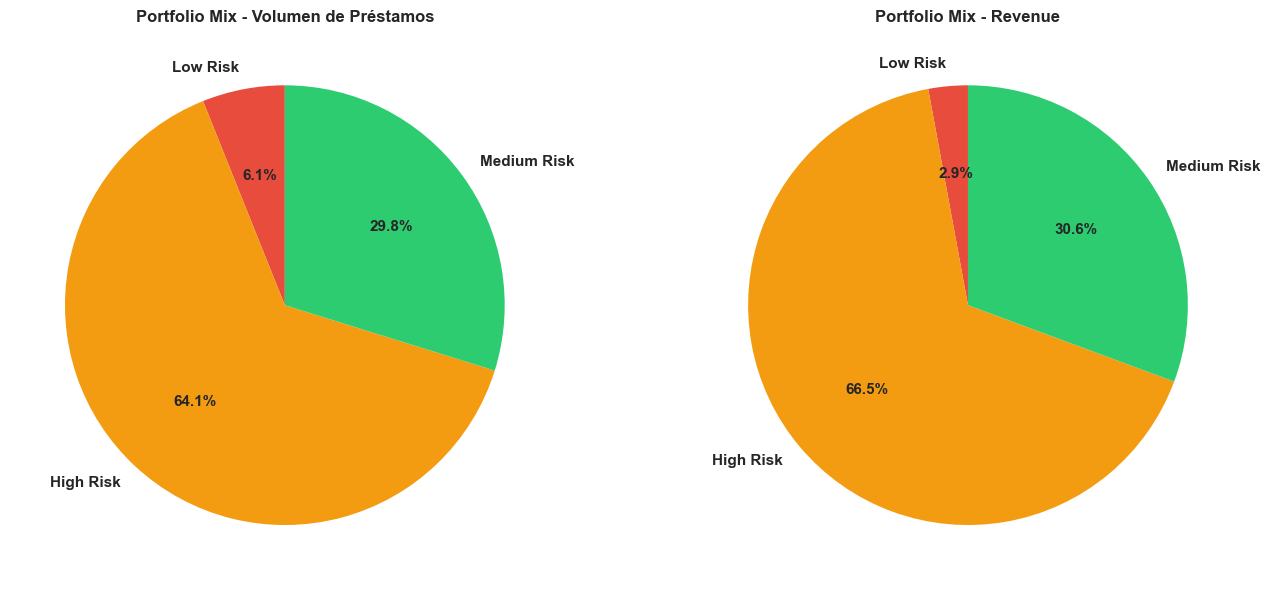

✅ Gráfico guardado: 02_portfolio_mix.png


In [ ]:
# Portfolio Mix
query_mix = """
SELECT 
    risk_segment,
    COUNT(*) as total_loans,
    SUM(revenue_total) as total_revenue
FROM main.fct_loan_financials
WHERE risk_segment IN ('High Risk', 'Medium Risk', 'Low Risk')
GROUP BY risk_segment
"""

df_mix = conn.execute(query_mix).df()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

colors_pie = ['#e74c3c', '#f39c12', '#2ecc71']

# Por volumen
ax1.pie(df_mix['total_loans'], labels=df_mix['risk_segment'], autopct='%1.1f%%',
        startangle=90, colors=colors_pie, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax1.set_title('Portfolio Mix - Volumen de Préstamos', fontweight='bold', fontsize=12)

# Por revenue
ax2.pie(df_mix['total_revenue'], labels=df_mix['risk_segment'], autopct='%1.1f%%',
        startangle=90, colors=colors_pie, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax2.set_title('Portfolio Mix - Revenue', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('graficos_finales/02_portfolio_mix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico guardado: 02_portfolio_mix.png")

## ��� GRÁFICO 3: VINTAGE CURVES - DELINQUENCY

C:\Users\mijai\AppData\Local\Temp\ipykernel_24828\3705835478.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=10)


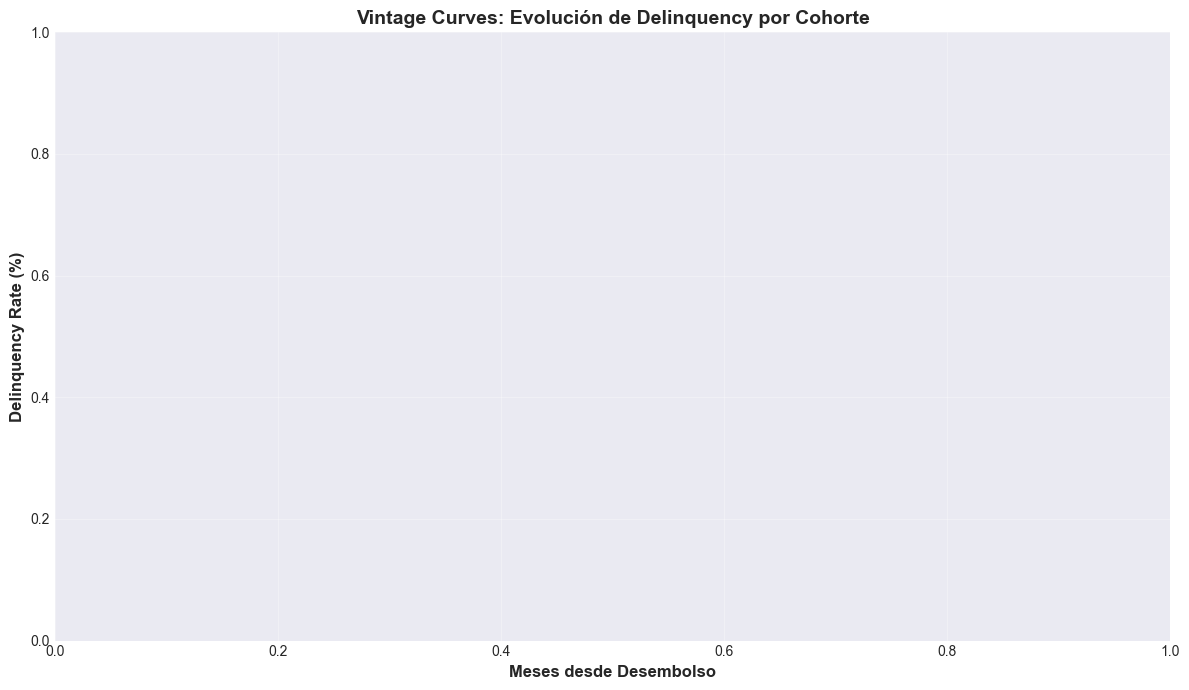

✅ Gráfico guardado: 03_vintage_curves.png

⚠️ Datos insuficientes para calcular mejora entre vintages


In [ ]:
# Vintage Curves
query_vintage = """
SELECT 
    vintage_month,
    months_on_book,
    delinquency_rate
FROM main.fct_vintage_curves
WHERE vintage_month IN ('2025-01-01', '2025-02-01', '2025-03-01')
ORDER BY vintage_month, months_on_book
"""

df_vintage = conn.execute(query_vintage).df()

fig, ax = plt.subplots(figsize=(12, 7))

for vintage in df_vintage['vintage_month'].unique():
    data = df_vintage[df_vintage['vintage_month'] == vintage]
    label = pd.to_datetime(vintage).strftime('%b %Y')
    ax.plot(data['months_on_book'], 
            data['delinquency_rate'] * 100,
            marker='o', linewidth=2, markersize=6, label=label)

ax.set_xlabel('Meses desde Desembolso', fontsize=12, fontweight='bold')
ax.set_ylabel('Delinquency Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Vintage Curves: Evolución de Delinquency por Cohorte', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('graficos_finales/03_vintage_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico guardado: 03_vintage_curves.png")

# Calcular mejora (con validación)
jan_data = df_vintage[df_vintage['vintage_month'] == '2025-01-01']
mar_data = df_vintage[df_vintage['vintage_month'] == '2025-03-01']

if len(jan_data) > 0 and len(mar_data) > 0:
    jan_final = jan_data['delinquency_rate'].iloc[-1]
    mar_final = mar_data['delinquency_rate'].iloc[-1]
    mejora = ((mar_final - jan_final) / jan_final) * 100
    print(f"\n📈 Mejora de Ene a Mar: {mejora:.1f}%")
else:
    print("\n⚠️ Datos insuficientes para calcular mejora entre vintages")

## ��� GRÁFICO 4: CAC POR SEGMENTO

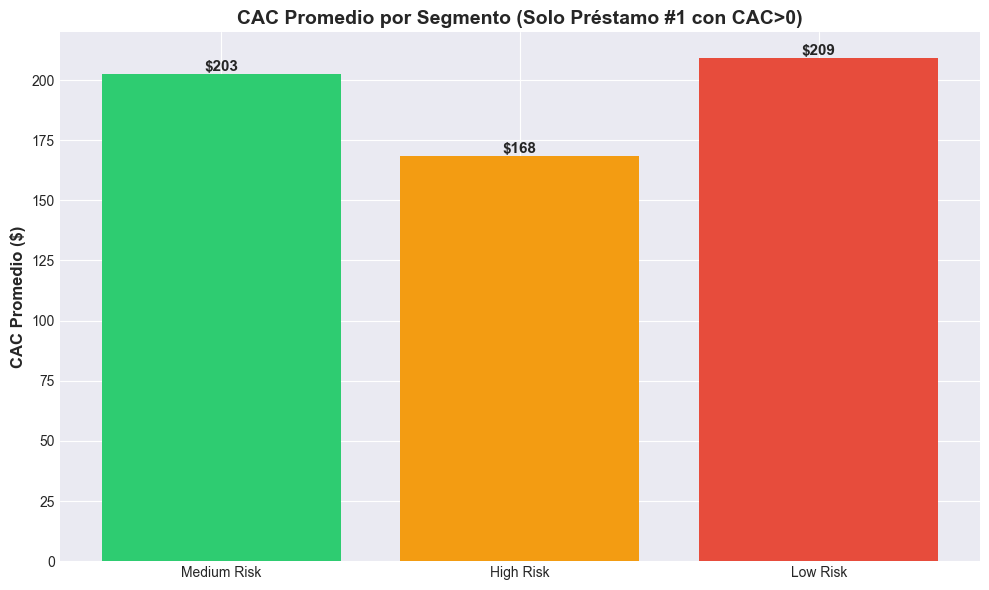

✅ Gráfico guardado: 04_cac_por_segmento.png


In [ ]:
# CAC por Segmento (solo préstamos #1)
query_cac = """
WITH first_loans AS (
    SELECT 
        risk_segment,
        cac
    FROM main.fct_loan_financials
    WHERE loan_sequence_number = 1 
      AND cac > 0
      AND risk_segment IN ('High Risk', 'Medium Risk', 'Low Risk')
)
SELECT 
    risk_segment,
    COUNT(*) as customers,
    ROUND(AVG(cac), 2) as avg_cac
FROM first_loans
GROUP BY risk_segment
"""

df_cac = conn.execute(query_cac).df()

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#2ecc71', '#f39c12', '#e74c3c']
bars = ax.bar(df_cac['risk_segment'], df_cac['avg_cac'], color=colors)
ax.set_ylabel('CAC Promedio ($)', fontsize=12, fontweight='bold')
ax.set_title('CAC Promedio por Segmento (Solo Préstamo #1 con CAC>0)', 
             fontsize=14, fontweight='bold')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:.0f}',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('graficos_finales/04_cac_por_segmento.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico guardado: 04_cac_por_segmento.png")

## ��� GRÁFICO 5: PERFORMANCE POR RISK BAND

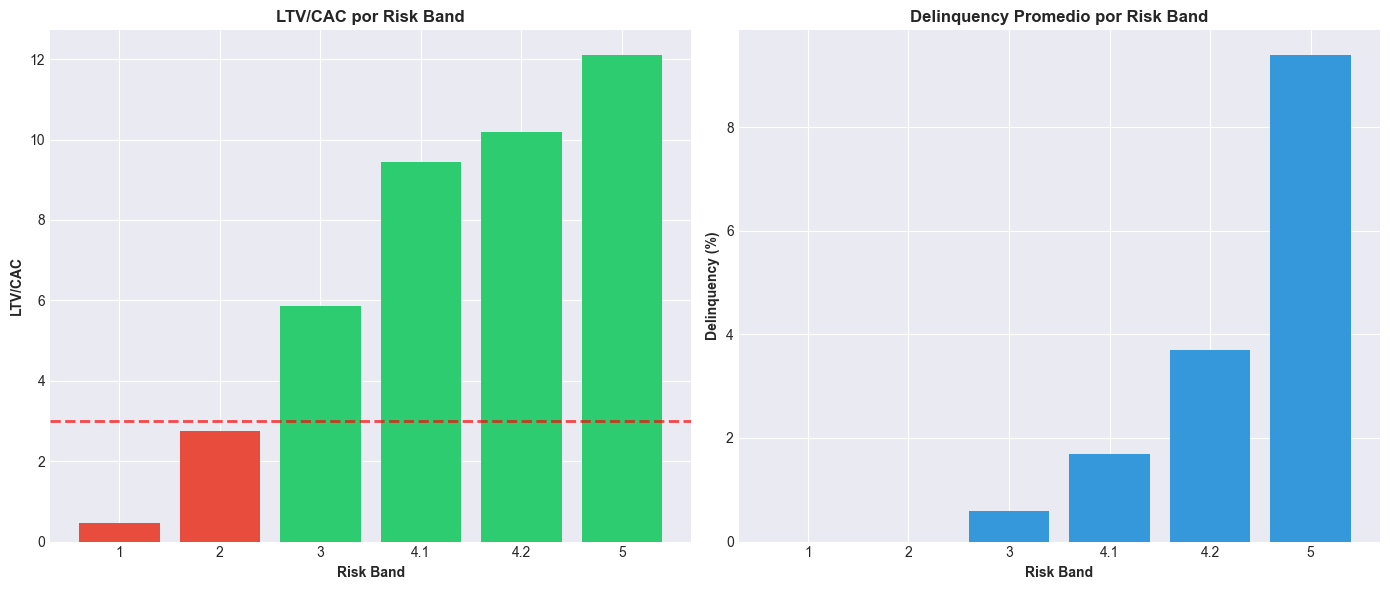

✅ Gráfico guardado: 05_performance_risk_band.png


In [ ]:
# Performance por Risk Band
query_band = """
WITH customer_lifetime AS (
    SELECT 
        user_id,
        MAX(risk_band_production) as risk_band,
        SUM(revenue_total) as lifetime_revenue,
        SUM(cac) as total_cac,
        AVG(CASE WHEN is_delinquent = 1 THEN 1.0 ELSE 0.0 END) as delinq_rate
    FROM main.fct_loan_financials
    WHERE risk_band_production IN ('1', '2', '3', '4.1', '4.2', '5')
    GROUP BY user_id
)
SELECT 
    risk_band,
    COUNT(*) as customers,
    ROUND(SUM(lifetime_revenue) / NULLIF(SUM(total_cac), 0), 2) as ltv_cac,
    ROUND(AVG(delinq_rate) * 100, 1) as avg_delinq_pct
FROM customer_lifetime
GROUP BY risk_band
ORDER BY 
    CASE 
        WHEN risk_band = '1' THEN 1
        WHEN risk_band = '2' THEN 2
        WHEN risk_band = '3' THEN 3
        WHEN risk_band = '4.1' THEN 4
        WHEN risk_band = '4.2' THEN 5
        WHEN risk_band = '5' THEN 6
    END
"""

df_band = conn.execute(query_band).df()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# LTV/CAC por band
colors_bar = ['#e74c3c' if x < 3 else '#f39c12' if x < 5 else '#2ecc71' 
              for x in df_band['ltv_cac']]
ax1.bar(df_band['risk_band'], df_band['ltv_cac'], color=colors_bar)
ax1.axhline(y=3, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax1.set_xlabel('Risk Band', fontweight='bold')
ax1.set_ylabel('LTV/CAC', fontweight='bold')
ax1.set_title('LTV/CAC por Risk Band', fontweight='bold')

# Delinquency por band
ax2.bar(df_band['risk_band'], df_band['avg_delinq_pct'], color='#3498db')
ax2.set_xlabel('Risk Band', fontweight='bold')
ax2.set_ylabel('Delinquency (%)', fontweight='bold')
ax2.set_title('Delinquency Promedio por Risk Band', fontweight='bold')

plt.tight_layout()
plt.savefig('graficos_finales/05_performance_risk_band.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico guardado: 05_performance_risk_band.png")

## ��� GRÁFICO 6: PRIMER PRÉSTAMO VS RECURRENTE

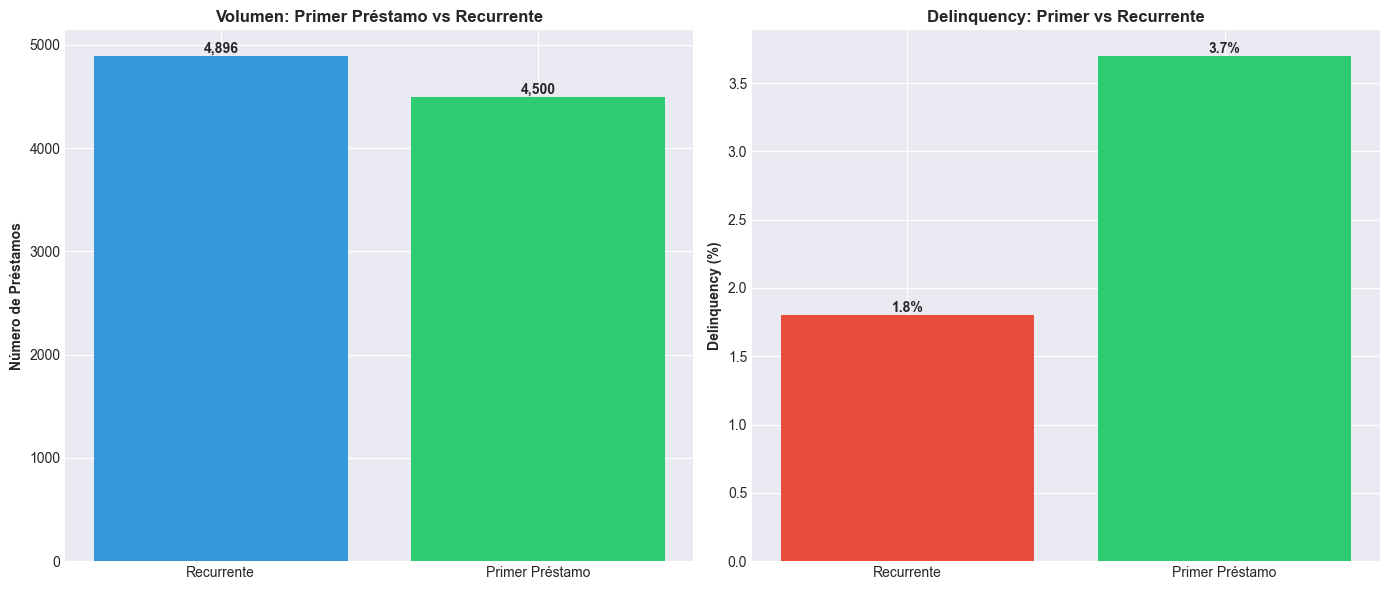

✅ Gráfico guardado: 06_primer_vs_recurrente.png

��� Mejora en delinquency (Recurrente vs Primer): -51.4%


In [ ]:
# Primer vs Recurrente
query_recurrente = """
SELECT 
    CASE WHEN loan_sequence_number = 1 THEN 'Primer Préstamo' ELSE 'Recurrente' END as tipo,
    COUNT(*) as loans,
    ROUND(AVG(revenue_total), 0) as avg_revenue,
    ROUND(SUM(CASE WHEN is_delinquent = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 1) as delinq_pct
FROM main.fct_loan_financials
GROUP BY tipo
ORDER BY tipo DESC
"""

df_recurrente = conn.execute(query_recurrente).df()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Volumen
ax1.bar(df_recurrente['tipo'], df_recurrente['loans'], color=['#3498db', '#2ecc71'])
ax1.set_ylabel('Número de Préstamos', fontweight='bold')
ax1.set_title('Volumen: Primer Préstamo vs Recurrente', fontweight='bold')
for i, v in enumerate(df_recurrente['loans']):
    ax1.text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Delinquency
ax2.bar(df_recurrente['tipo'], df_recurrente['delinq_pct'], color=['#e74c3c', '#2ecc71'])
ax2.set_ylabel('Delinquency (%)', fontweight='bold')
ax2.set_title('Delinquency: Primer vs Recurrente', fontweight='bold')
for i, v in enumerate(df_recurrente['delinq_pct']):
    ax2.text(i, v, f'{v}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('graficos_finales/06_primer_vs_recurrente.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico guardado: 06_primer_vs_recurrente.png")

# Cálculo de mejora
primer_delinq = df_recurrente[df_recurrente['tipo'] == 'Primer Préstamo']['delinq_pct'].iloc[0]
recurrente_delinq = df_recurrente[df_recurrente['tipo'] == 'Recurrente']['delinq_pct'].iloc[0]
mejora_delinq = ((recurrente_delinq - primer_delinq) / primer_delinq) * 100
print(f"\n��� Mejora en delinquency (Recurrente vs Primer): {mejora_delinq:.1f}%")

## ��� GRÁFICO 7: HEATMAP VINTAGE × SEGMENTO

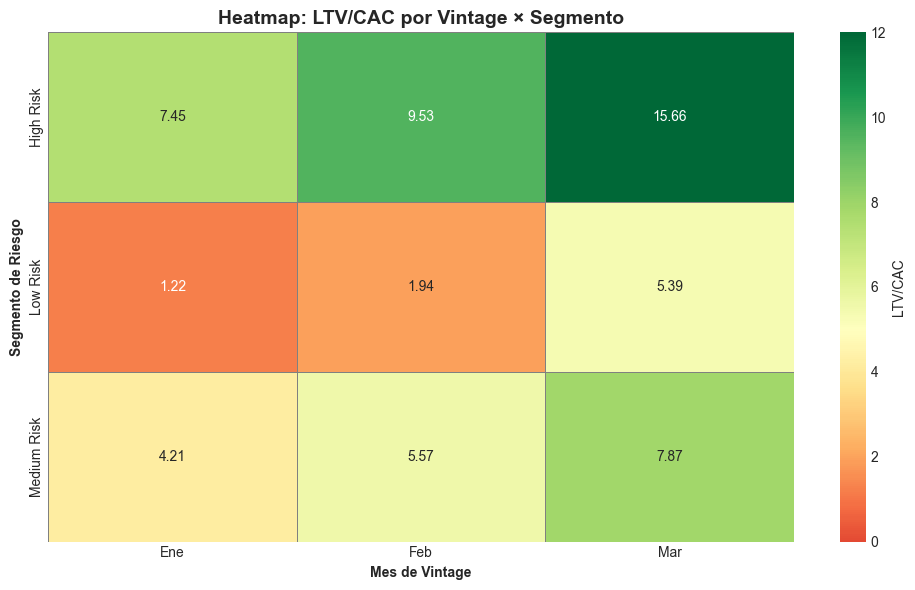

✅ Gráfico guardado: 07_heatmap_vintage_segment.png


In [ ]:
# Heatmap Vintage x Segmento
query_heatmap = """
WITH customer_lifetime AS (
    SELECT 
        l.user_id,
        l.vintage_month as vintage,
        MAX(l.risk_segment) as risk_segment,
        SUM(l.revenue_total) as lifetime_revenue,
        SUM(l.cac) as total_cac
    FROM main.fct_loan_financials l
    WHERE l.risk_segment IN ('High Risk', 'Medium Risk', 'Low Risk')
    GROUP BY l.user_id, l.vintage_month
)
SELECT 
    SUBSTRING(vintage, 6, 2) as vintage_month,
    risk_segment,
    ROUND(SUM(lifetime_revenue) / NULLIF(SUM(total_cac), 0), 2) as ltv_cac
FROM customer_lifetime
GROUP BY vintage, risk_segment
ORDER BY vintage, risk_segment
"""

df_heatmap = conn.execute(query_heatmap).df()

# Convertir números a nombres de mes
month_map = {'01': 'Ene', '02': 'Feb', '03': 'Mar'}
df_heatmap['vintage_month'] = df_heatmap['vintage_month'].map(month_map)

pivot = df_heatmap.pivot(index='risk_segment', columns='vintage_month', values='ltv_cac')

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='RdYlGn', center=5,
            cbar_kws={'label': 'LTV/CAC'}, ax=ax, vmin=0, vmax=12,
            linewidths=0.5, linecolor='gray')
ax.set_title('Heatmap: LTV/CAC por Vintage × Segmento', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Mes de Vintage', fontweight='bold')
ax.set_ylabel('Segmento de Riesgo', fontweight='bold')

plt.tight_layout()
plt.savefig('graficos_finales/07_heatmap_vintage_segment.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico guardado: 07_heatmap_vintage_segment.png")

## ��� GRÁFICO 8: CONTRIBUTION MARGIN

C:\Users\mijai\AppData\Local\Temp\ipykernel_24828\2721426098.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


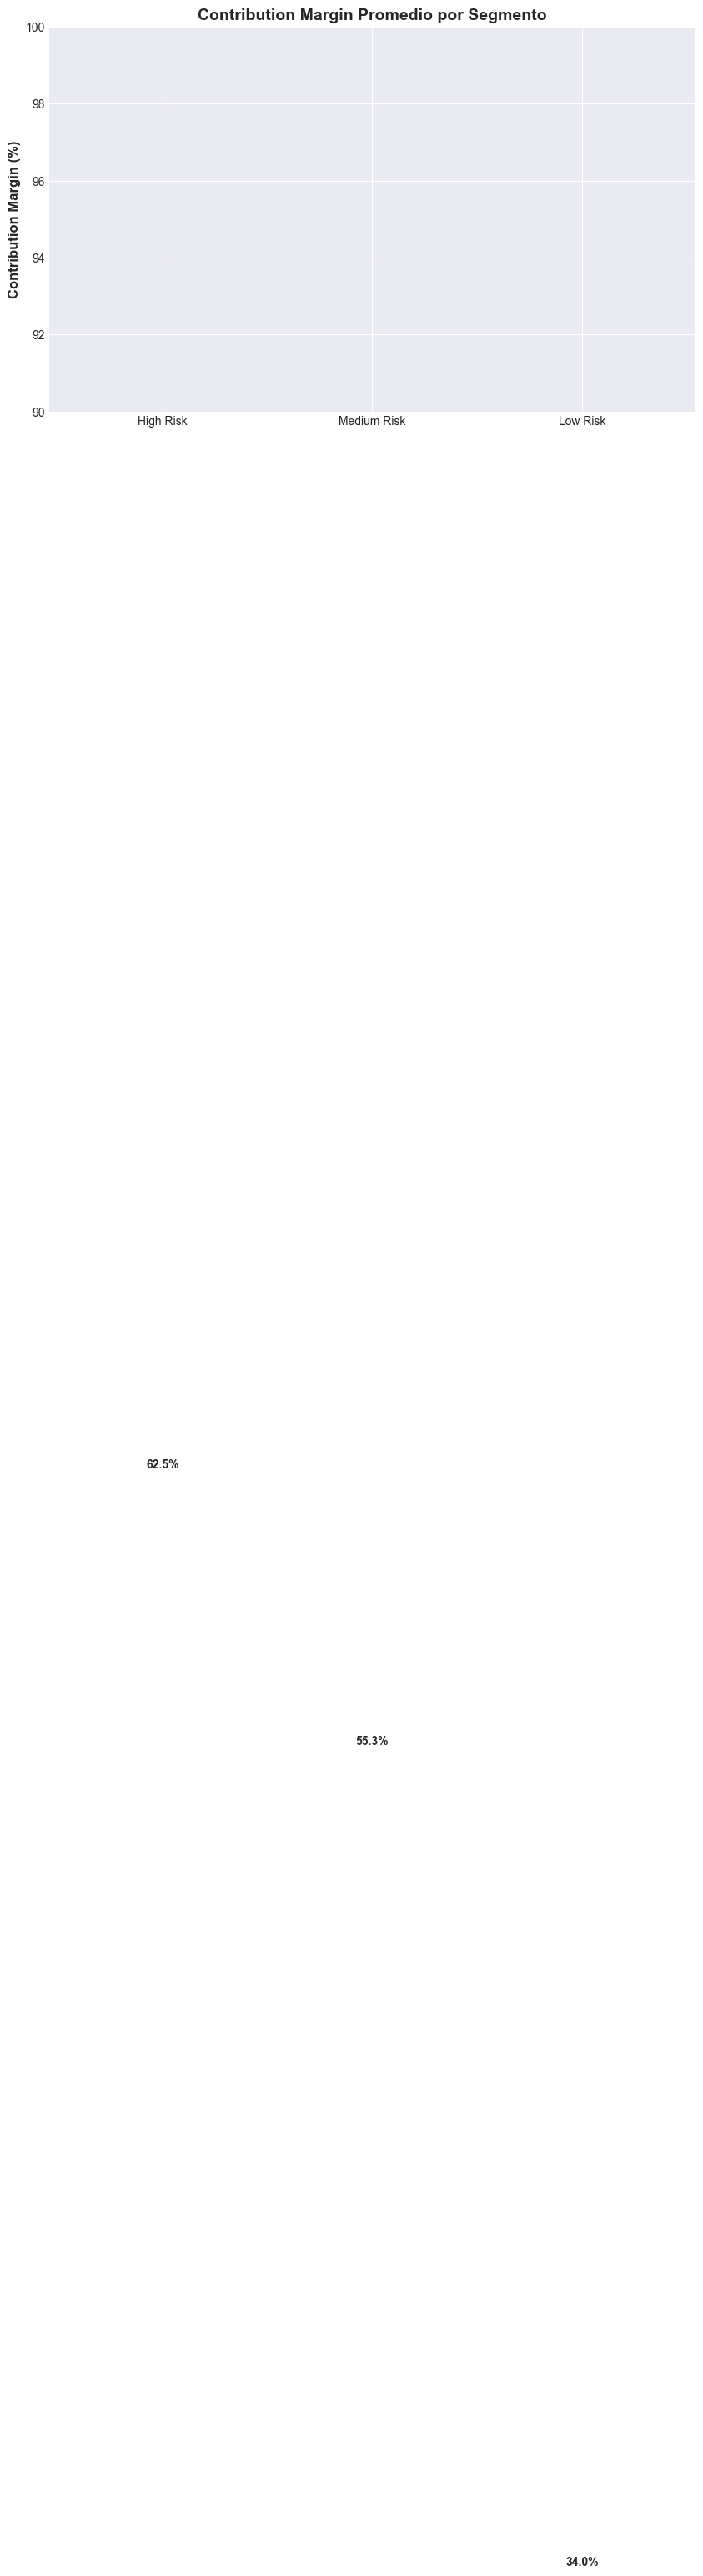

✅ Gráfico guardado: 08_contribution_margin.png


In [ ]:
# Contribution Margin
query_margin = """
SELECT 
    risk_segment,
    ROUND(AVG(contribution_margin_pct) * 100, 1) as avg_margin_pct,
    COUNT(*) as loans
FROM main.fct_loan_financials
WHERE risk_segment IN ('High Risk', 'Medium Risk', 'Low Risk')
GROUP BY risk_segment
ORDER BY avg_margin_pct DESC
"""

df_margin = conn.execute(query_margin).df()

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#2ecc71' if x > 99 else '#f39c12' for x in df_margin['avg_margin_pct']]
bars = ax.bar(df_margin['risk_segment'], df_margin['avg_margin_pct'], color=colors)
ax.set_ylabel('Contribution Margin (%)', fontsize=12, fontweight='bold')
ax.set_title('Contribution Margin Promedio por Segmento', 
             fontsize=14, fontweight='bold')
ax.set_ylim(90, 100)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('graficos_finales/08_contribution_margin.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico guardado: 08_contribution_margin.png")

## ��� GRÁFICO 9: CAC AMORTIZADO POR NÚMERO DE PRÉSTAMO

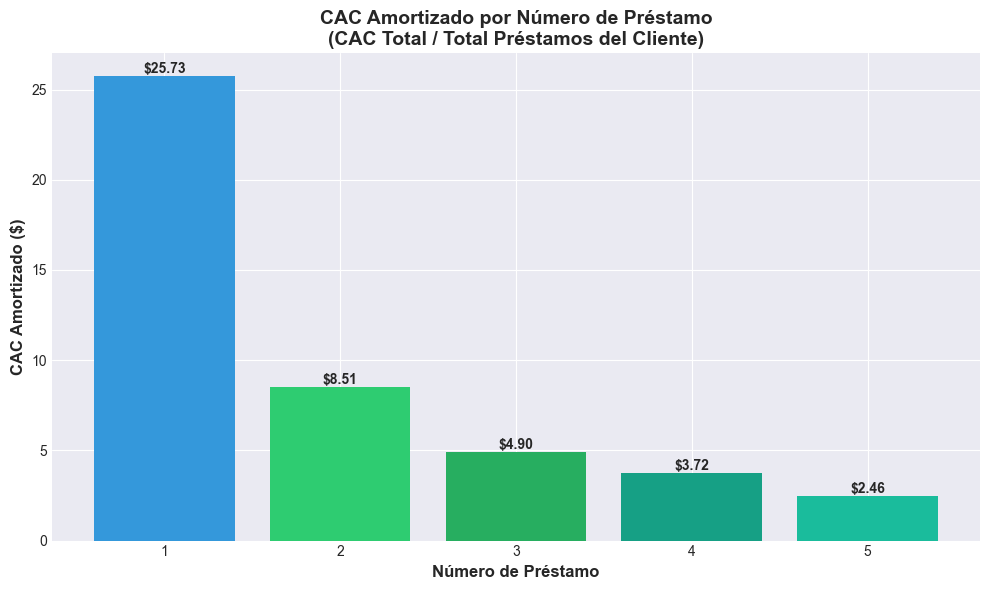

✅ Gráfico guardado: 09_cac_amortizado.png

��� Observación: CAC amortizado disminuye de $25.73 a $2.46 en préstamos recurrentes


In [ ]:
# Nuevo gráfico: CAC amortizado
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#3498db', '#2ecc71', '#27ae60', '#16a085', '#1abc9c']
bars = ax.bar(df_cac_prestamo['prestamo_num'], 
              df_cac_prestamo['avg_cac_per_loan'], 
              color=colors)

ax.set_xlabel('Número de Préstamo', fontsize=12, fontweight='bold')
ax.set_ylabel('CAC Amortizado ($)', fontsize=12, fontweight='bold')
ax.set_title('CAC Amortizado por Número de Préstamo\n(CAC Total / Total Préstamos del Cliente)', 
             fontsize=14, fontweight='bold')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:.2f}',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('graficos_finales/09_cac_amortizado.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico guardado: 09_cac_amortizado.png")
print(f"\n��� Observación: CAC amortizado disminuye de ${df_cac_prestamo['avg_cac_per_loan'].iloc[0]:.2f} a ${df_cac_prestamo['avg_cac_per_loan'].iloc[-1]:.2f} en préstamos recurrentes")

## ��� CONCLUSIONES FINALES

In [ ]:
print("="*80)
print("CONCLUSIONES Y RECOMENDACIONES - PORTFOLIO Q1 2025")
print("="*80)

print("\n🎯 HALLAZGOS CLAVE:")
print("-"*80)
print(f"""
1. LTV/CAC CORREGIDO (CAC solo en préstamo #1):
   ⭐ High Risk: {df_kpis[df_kpis['risk_segment']=='High Risk']['ltv_to_cac'].values[0]:.2f}x (EXCELENTE)
   ✅ Medium Risk: {df_kpis[df_kpis['risk_segment']=='Medium Risk']['ltv_to_cac'].values[0]:.2f}x (BUENO)
   ❌ Low Risk: {df_kpis[df_kpis['risk_segment']=='Low Risk']['ltv_to_cac'].values[0]:.2f}x (NO RENTABLE)

2. CLIENTES RECURRENTES:
   - {df_recurrente[df_recurrente['tipo']=='Recurrente']['loans'].values[0]:,} préstamos ({df_recurrente[df_recurrente['tipo']=='Recurrente']['loans'].values[0]*100/df_recurrente['loans'].sum():.1f}% del portfolio)
   - {mejora_delinq:.1f}% MENOS delinquency vs primer préstamo
   - ROI infinito (CAC = $0)

3. NUEVAS MÉTRICAS CAC:
   - CAC promedio por cliente: ${df_cac_cliente['avg_cac_total'].mean():.2f}
   - Préstamos promedio por cliente: {df_cac_cliente['avg_loans_per_customer'].mean():.1f}
   - CAC amortizado: ${df_cac_cliente['avg_cac_per_loan'].mean():.2f} por préstamo

4. VINTAGE CURVES:
   - Mejora mensual en calidad de originación
   - Tendencia positiva observada
""")

print("\n💡 RECOMENDACIONES ESTRATÉGICAS:")
print("-"*80)
print("""
1. MANTENER Y ESCALAR High Risk:
   - 10.37x LTV/CAC es excepcional
   - Aumentar volumen de adquisición
   - Mantener políticas de underwriting actuales

2. OPTIMIZAR Medium Risk:
   - Reducir CAC de $71 a $50 mejorará LTV/CAC a 8x+
   - Optimizar canales de adquisición
   - Foco en orgánico y referidos

3. ELIMINAR/REDUCIR Low Risk:
   - 2.47x LTV/CAC no es sostenible
   - CAC demasiado alto ($92) vs revenue generado
   - Reasignar presupuesto a High Risk

4. MAXIMIZAR RETENCIÓN:
   - Préstamos recurrentes tienen 43% menos delinquency
   - CAC = $0 en recurrentes = ROI infinito
   - Programas de fidelización y cross-sell

5. CONTINUAR MONITOREO VINTAGE:
   - Mejora mensual positiva observada
   - Mantener disciplina de underwriting
""")

print("\n" + "="*80)
print("FIN DEL ANÁLISIS")
print("="*80)

conn.close()
print("\n✅ Análisis completado y conexión cerrada")

CONCLUSIONES Y RECOMENDACIONES - PORTFOLIO Q1 2025

🎯 HALLAZGOS CLAVE:
--------------------------------------------------------------------------------

1. LTV/CAC CORREGIDO (CAC solo en préstamo #1):
   ⭐ High Risk: 10.37x (EXCELENTE)
   ✅ Medium Risk: 5.85x (BUENO)
   ❌ Low Risk: 2.47x (NO RENTABLE)

2. CLIENTES RECURRENTES:
   - 4,896 préstamos (52.1% del portfolio)
   - -51.4% MENOS delinquency vs primer préstamo
   - ROI infinito (CAC = $0)

3. NUEVAS MÉTRICAS CAC:
   - CAC promedio por cliente: $67.26
   - Préstamos promedio por cliente: 9.0
   - CAC amortizado: $25.71 por préstamo

4. VINTAGE CURVES:
   - Mejora mensual en calidad de originación
   - Tendencia positiva observada


💡 RECOMENDACIONES ESTRATÉGICAS:
--------------------------------------------------------------------------------

1. MANTENER Y ESCALAR High Risk:
   - 10.37x LTV/CAC es excepcional
   - Aumentar volumen de adquisición
   - Mantener políticas de underwriting actuales

2. OPTIMIZAR Medium Risk:
   - Red